## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


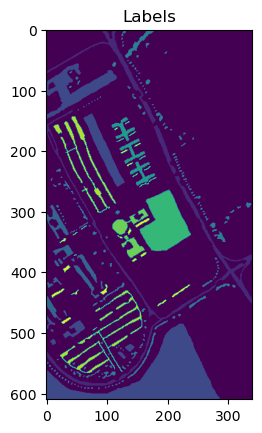

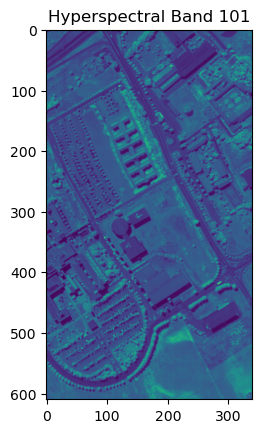

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 5 training sam


All datasets saved to the 'indices' folder.
(45, 5, 5, 103)
(45, 5, 5, 103)
(42686, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1233, PSNR: 7.2303


	 Training Batch [200/535], Loss: 0.0601, PSNR: 10.3110


	 Training Batch [400/535], Loss: 0.0245, PSNR: 13.9118


Epoch [1/50] Training Loss: 0.0552, PSNR: 11.1855
	[Val]   Batch [1/134] Loss: 0.0191, PSNR: 15.3859
	[Val]   Batch [10/134] Loss: 0.0168, PSNR: 17.7437
	[Val]   Batch [20/134] Loss: 0.0181, PSNR: 15.5335
	[Val]   Batch [30/134] Loss: 0.0196, PSNR: 15.0076
	[Val]   Batch [40/134] Loss: 0.0178, PSNR: 14.0472
	[Val]   Batch [50/134] Loss: 0.0189, PSNR: 15.2161


	[Val]   Batch [60/134] Loss: 0.0171, PSNR: 15.8652
	[Val]   Batch [70/134] Loss: 0.0162, PSNR: 16.0765
	[Val]   Batch [80/134] Loss: 0.0159, PSNR: 16.0520
	[Val]   Batch [90/134] Loss: 0.0167, PSNR: 16.0525
	[Val]   Batch [100/134] Loss: 0.0189, PSNR: 15.4486
	[Val]   Batch [110/134] Loss: 0.0192, PSNR: 13.9752
	[Val]   Batch [120/134] Loss: 0.0157, PSNR: 15.1415
	[Val]   Batch [130/134] Loss: 0.0174, PSNR: 13.1444


Epoch [1/50] Validation Loss: 0.0181, PSNR: 15.4018

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0171, PSNR: 15.8621


	 Training Batch [200/535], Loss: 0.0120, PSNR: 17.4506


	 Training Batch [400/535], Loss: 0.0081, PSNR: 19.1312


Epoch [2/50] Training Loss: 0.0117, PSNR: 17.4306
	[Val]   Batch [1/134] Loss: 0.0086, PSNR: 18.8558
	[Val]   Batch [10/134] Loss: 0.0069, PSNR: 21.6111
	[Val]   Batch [20/134] Loss: 0.0075, PSNR: 19.3455
	[Val]   Batch [30/134] Loss: 0.0085, PSNR: 18.6456
	[Val]   Batch [40/134] Loss: 0.0076, PSNR: 17.7168
	[Val]   Batch [50/134] Loss: 0.0079, PSNR: 18.9968
	[Val]   Batch [60/134] Loss: 0.0070, PSNR: 19.7768


	[Val]   Batch [70/134] Loss: 0.0067, PSNR: 19.9085
	[Val]   Batch [80/134] Loss: 0.0065, PSNR: 19.9671
	[Val]   Batch [90/134] Loss: 0.0068, PSNR: 19.9268
	[Val]   Batch [100/134] Loss: 0.0082, PSNR: 19.0752
	[Val]   Batch [110/134] Loss: 0.0078, PSNR: 17.9050
	[Val]   Batch [120/134] Loss: 0.0057, PSNR: 19.5173
	[Val]   Batch [130/134] Loss: 0.0070, PSNR: 17.0880
Epoch [2/50] Validation Loss: 0.0078, PSNR: 19.0944

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0078, PSNR: 19.2328


	 Training Batch [200/535], Loss: 0.0076, PSNR: 19.2985


	 Training Batch [400/535], Loss: 0.0062, PSNR: 20.2747


Epoch [3/50] Training Loss: 0.0067, PSNR: 19.7581
	[Val]   Batch [1/134] Loss: 0.0060, PSNR: 20.4358
	[Val]   Batch [10/134] Loss: 0.0047, PSNR: 23.2666
	[Val]   Batch [20/134] Loss: 0.0051, PSNR: 21.0673
	[Val]   Batch [30/134] Loss: 0.0057, PSNR: 20.3636
	[Val]   Batch [40/134] Loss: 0.0052, PSNR: 19.3530
	[Val]   Batch [50/134] Loss: 0.0053, PSNR: 20.7468
	[Val]   Batch [60/134] Loss: 0.0046, PSNR: 21.5371


	[Val]   Batch [70/134] Loss: 0.0046, PSNR: 21.5587
	[Val]   Batch [80/134] Loss: 0.0044, PSNR: 21.6767
	[Val]   Batch [90/134] Loss: 0.0046, PSNR: 21.6086
	[Val]   Batch [100/134] Loss: 0.0056, PSNR: 20.7035
	[Val]   Batch [110/134] Loss: 0.0051, PSNR: 19.7709
	[Val]   Batch [120/134] Loss: 0.0036, PSNR: 21.5349
	[Val]   Batch [130/134] Loss: 0.0046, PSNR: 18.9241
Epoch [3/50] Validation Loss: 0.0053, PSNR: 20.7423

LOG: Epoch [4/50]


	 Training Batch [1/535], Loss: 0.0053, PSNR: 20.8728


	 Training Batch [200/535], Loss: 0.0045, PSNR: 21.6460


	 Training Batch [400/535], Loss: 0.0059, PSNR: 20.4675


Epoch [4/50] Training Loss: 0.0049, PSNR: 21.1625
	[Val]   Batch [1/134] Loss: 0.0042, PSNR: 21.9836
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.7436
	[Val]   Batch [20/134] Loss: 0.0034, PSNR: 22.8107
	[Val]   Batch [30/134] Loss: 0.0038, PSNR: 22.1182
	[Val]   Batch [40/134] Loss: 0.0035, PSNR: 21.0894
	[Val]   Batch [50/134] Loss: 0.0034, PSNR: 22.6329
	[Val]   Batch [60/134] Loss: 0.0033, PSNR: 22.9908


	[Val]   Batch [70/134] Loss: 0.0033, PSNR: 23.0557
	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.1877
	[Val]   Batch [90/134] Loss: 0.0033, PSNR: 23.1238
	[Val]   Batch [100/134] Loss: 0.0039, PSNR: 22.3206
	[Val]   Batch [110/134] Loss: 0.0033, PSNR: 21.6777
	[Val]   Batch [120/134] Loss: 0.0024, PSNR: 23.2591
	[Val]   Batch [130/134] Loss: 0.0030, PSNR: 20.7822
Epoch [4/50] Validation Loss: 0.0037, PSNR: 22.3363

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0032, PSNR: 21.9359


	 Training Batch [200/535], Loss: 0.0044, PSNR: 21.7222


	 Training Batch [400/535], Loss: 0.0031, PSNR: 21.5685


Epoch [5/50] Training Loss: 0.0036, PSNR: 22.5300
	[Val]   Batch [1/134] Loss: 0.0032, PSNR: 23.1687
	[Val]   Batch [10/134] Loss: 0.0026, PSNR: 25.9336
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.2659
	[Val]   Batch [30/134] Loss: 0.0028, PSNR: 23.5226
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.5616
	[Val]   Batch [50/134] Loss: 0.0024, PSNR: 24.1515
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0599


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2366
	[Val]   Batch [80/134] Loss: 0.0024, PSNR: 24.3329
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.2536
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.6278
	[Val]   Batch [110/134] Loss: 0.0022, PSNR: 23.3349
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.6694
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.2116
Epoch [5/50] Validation Loss: 0.0028, PSNR: 23.6026

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0031, PSNR: 23.2884


	 Training Batch [200/535], Loss: 0.0033, PSNR: 22.8772


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.6248


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.3760
	[Val]   Batch [1/134] Loss: 0.0027, PSNR: 23.8905
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.7102
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.2614
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.4261
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.5444
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.0963
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.7741


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0271
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 25.1185
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 24.9685
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.4676
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.4195
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.6732
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 23.1149
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.4319

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.5029


	 Training Batch [200/535], Loss: 0.0027, PSNR: 23.8807


	 Training Batch [400/535], Loss: 0.0027, PSNR: 24.0177


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0151
	[Val]   Batch [1/134] Loss: 0.0024, PSNR: 24.4332
	[Val]   Batch [10/134] Loss: 0.0019, PSNR: 27.2836
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.0146
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.1131
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.2777
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.8538
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3192


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.5918
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.6996
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.5065
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1116
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.2499
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.4241
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.7727
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.0583

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 23.5680


	 Training Batch [200/535], Loss: 0.0032, PSNR: 24.5059


	 Training Batch [400/535], Loss: 0.0027, PSNR: 23.8100


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.4555
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.8522
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.7177
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6363
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.6488
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.8742
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4200
	[Val]   Batch [60/134] Loss: 0.0018, PSNR: 25.7677
	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0347


	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.1676
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 25.9438
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6236
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9319
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0507
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3397
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.5689

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0026, PSNR: 24.0420


	 Training Batch [200/535], Loss: 0.0017, PSNR: 24.5545


	 Training Batch [400/535], Loss: 0.0021, PSNR: 23.8681


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.8355
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.1756
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 28.0658
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.1033
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.0601
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3110
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8225


	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1142
	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3874
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.5537
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.2898
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.9988
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4032
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.4814
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7437


Epoch [9/50] Validation Loss: 0.0017, PSNR: 25.9510

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.7364


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.8723


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.2365


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.1584
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4250
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3005
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4564
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3786
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6478
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1198
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.3851
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6410


	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8170
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5568
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2750
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.7724
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8076
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.0647
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2451

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.7927


	 Training Batch [200/535], Loss: 0.0020, PSNR: 26.9872


	 Training Batch [400/535], Loss: 0.0026, PSNR: 23.9338


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.3980
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6564
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.5462
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7744
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6268
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9517
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.3634
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6437


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9018
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.1106
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8180
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5199
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.0638
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.1269
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.3397
Epoch [11/50] Validation Loss: 0.0015, PSNR: 26.5174

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 25.0852


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0802


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.5803


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5796
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8074
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6760
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.9878
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8045
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.1294
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4982
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.8261


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.0481
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2743
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 26.9944
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6540
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.2028
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2803
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5005
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.6832

LOG: Epoch [13/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.7241


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.9915


	 Training Batch [400/535], Loss: 0.0022, PSNR: 26.5114


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8122
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1299
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9979
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.5033
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.2376
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5866
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9460
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1967


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3910
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6703
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3698
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0494
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7340
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7473
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9696
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0928

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 25.0830


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0434


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.3043


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9513
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3314
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1683
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.7963
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4629
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8444
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1612
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4546


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6521
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9107
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5997
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2826
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9653
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 28.9747
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2397
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3266

LOG: Epoch [15/50]


	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.2074


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.5481


	 Training Batch [400/535], Loss: 0.0013, PSNR: 28.9576


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1300
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5095
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3539
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0521
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6936
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0665
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3767
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6958


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8697
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1459
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8074
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5219
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1929
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1595
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4104
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.5423

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 26.7129


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.7966


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1342


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3259
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7287
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4852
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3204
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9046
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.2743
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5159


	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9413
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1109
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3622
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 28.0384
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7089
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2947
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2935
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.6579


Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7447

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.6340


	 Training Batch [200/535], Loss: 0.0011, PSNR: 26.7645


	 Training Batch [400/535], Loss: 0.0022, PSNR: 25.5737


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.4831
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9011
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6354
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.5764
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0943
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5032
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7084
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1676


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3539
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5728
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2449
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9247
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.4257
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4635
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8443
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9438

LOG: Epoch [18/50]


	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.5939


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4539


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2596


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.7080
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1500
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8418
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8921
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4350
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8160
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0076
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4917
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.6407


	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8718
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5538
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2305
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7190
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6847
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1909
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.2339

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.7278


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.9696


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.3191


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.8668
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3942
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0284
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.2308
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.7388
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0650
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3157
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7812
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 28.9253


	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.1569
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.8480
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.5025
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9521
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8627
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.4109
Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.4887

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 27.5159


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.2142


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.8291


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9981
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6400
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2263
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4760
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0476
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.3625
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.5802
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0686


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.2016
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.4199
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1219
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7961
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1719
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0170
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6724
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.7554

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.7448


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.9514


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.0353


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.1958
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7724
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3314
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.5256
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.1612
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4576
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6470
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1849


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3700
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5459
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2566
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.8913
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1277
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9958
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7368
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.8585

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0489


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.9432


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.7871


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.4299
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.1409
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6398
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9631
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6008
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8521
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0567
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.5779


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7636
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.9205
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.6566
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.2649
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4991
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3022
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1518


Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.2364

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8745


	 Training Batch [200/535], Loss: 0.0014, PSNR: 28.4097


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9481


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.4966
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.4083
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8933
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.2180
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.8776
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.0889
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.3658
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8515


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 30.0351
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2171
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.9756
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.5878
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7264
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5239
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3720


Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.5077

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.3194


	 Training Batch [200/535], Loss: 0.0021, PSNR: 26.7108


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9597


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6443
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.5980
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0466
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3635
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.0802
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2046
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5190
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 30.0240


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.1837
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4365
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.1578
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7664
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7608
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6252
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4651
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.6770

LOG: Epoch [25/50]


	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.9113


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.8303


	 Training Batch [400/535], Loss: 0.0008, PSNR: 29.1197


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.8560
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8904
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.2487
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5422
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3913
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4269
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7495


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1940
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4371
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5916
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4022
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0231
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9321
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6942


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6754
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.9106

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.4321


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.2503


	 Training Batch [400/535], Loss: 0.0008, PSNR: 28.9322


Epoch [26/50] Training Loss: 0.0010, PSNR: 27.9808
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0184
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4319
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6167
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4909
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4516
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8214
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3370


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5775
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7521
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5754
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1302
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9385
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8097
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7001
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.0277

LOG: Epoch [27/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.1126


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.7447


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.5941


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.1109
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.1983
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5869
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7182
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7280
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5843
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0677
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4635


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6979
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9007
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7874
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3568
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1200
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8741
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8376
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.2187

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 28.0110


	 Training Batch [200/535], Loss: 0.0008, PSNR: 28.7571


	 Training Batch [400/535], Loss: 0.0006, PSNR: 29.2618


Epoch [28/50] Training Loss: 0.0009, PSNR: 28.2207
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.4843
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7391
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.9292
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.9241
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7160
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.2215
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5882


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.9683
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0213
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.9404
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5738
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1610
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9134
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9766
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.3983
Early stopping triggered at epoch 28. No improvement for 3 epochs.


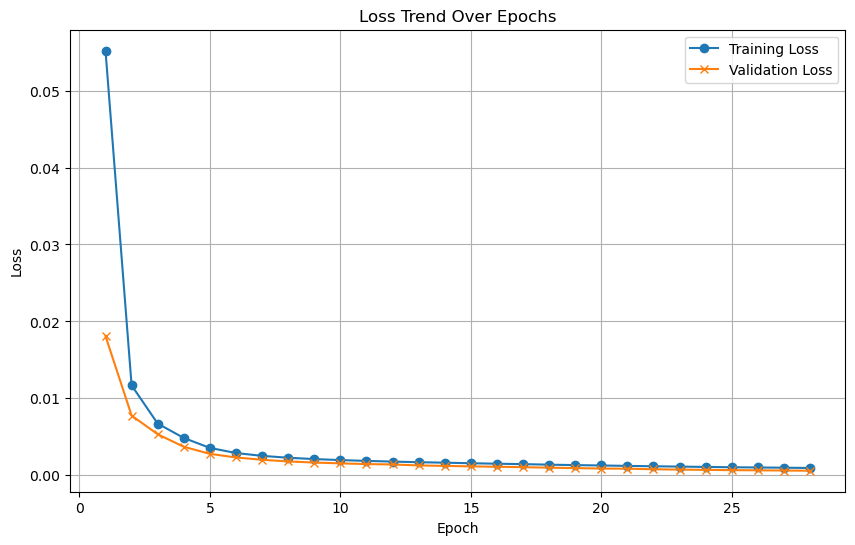

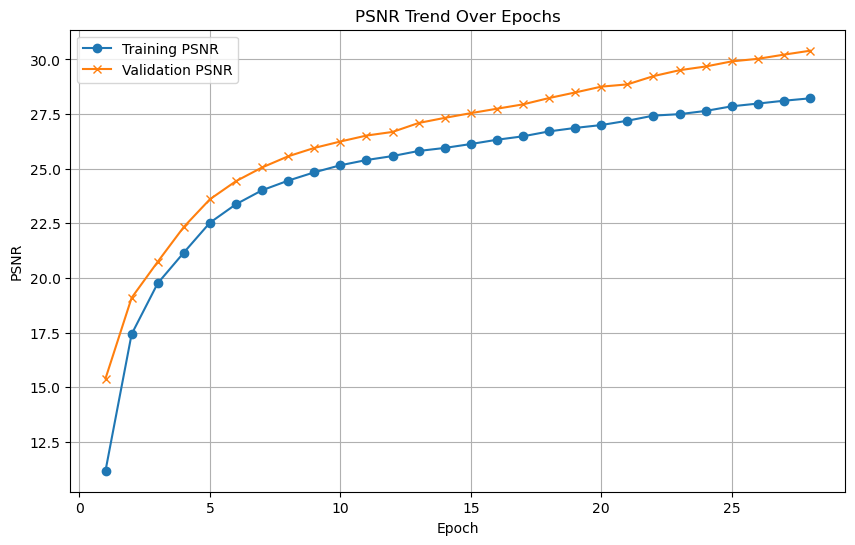

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2332
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2010. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1914
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1351
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1160
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss improved from 2.2010 to 2.2010. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] co

Epoch [26/1000] completed, Average Training Loss: 1.7045
    Validation Batch [1/1], Loss: 2.1652
Validation Loss: 2.1652, Validation Accuracy: 11.11%
Validation loss improved from 2.1707 to 2.1652. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 1.7082
    Validation Batch [1/1], Loss: 2.1590
Validation Loss: 2.1590, Validation Accuracy: 20.00%
Validation loss improved from 2.1652 to 2.1590. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 1.7308
    Validation Batch [1/1], Loss: 2.1520
Validation Loss: 2.1520, Validation Accuracy: 22.22%
Validation loss improved from 2.1590 to 2.1520. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 1.7355
    Validation Batch [1/1], Loss: 2.1441
Validation Loss: 2.1441, Validation Accuracy: 22.22%
Validation loss improved from 2.1520 to 2.1441. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [3

Epoch [58/1000] completed, Average Training Loss: 1.4701
    Validation Batch [1/1], Loss: 1.7136
Validation Loss: 1.7136, Validation Accuracy: 62.22%
Validation loss improved from 1.7268 to 1.7136. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.3671
    Validation Batch [1/1], Loss: 1.7029
Validation Loss: 1.7029, Validation Accuracy: 66.67%
Validation loss improved from 1.7136 to 1.7029. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.4595
    Validation Batch [1/1], Loss: 1.6932
Validation Loss: 1.6932, Validation Accuracy: 71.11%
Validation loss improved from 1.7029 to 1.6932. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.3822
    Validation Batch [1/1], Loss: 1.6842
Validation Loss: 1.6842, Validation Accuracy: 71.11%
Validation loss improved from 1.6932 to 1.6842. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 1.4840
Validation Loss: 1.4840, Validation Accuracy: 77.78%
Validation loss improved from 1.4894 to 1.4840. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.2240
    Validation Batch [1/1], Loss: 1.4768
Validation Loss: 1.4768, Validation Accuracy: 77.78%
Validation loss improved from 1.4840 to 1.4768. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.2192
    Validation Batch [1/1], Loss: 1.4698
Validation Loss: 1.4698, Validation Accuracy: 80.00%
Validation loss improved from 1.4768 to 1.4698. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.1757
    Validation Batch [1/1], Loss: 1.4656
Validation Loss: 1.4656, Validation Accuracy: 77.78%
Validation loss improved from 1.4698 to 1.4656. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.2595
    Vali

    Validation Batch [1/1], Loss: 1.3216
Validation Loss: 1.3216, Validation Accuracy: 73.33%
Validation loss improved from 1.3353 to 1.3216. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.9908
    Validation Batch [1/1], Loss: 1.3076
Validation Loss: 1.3076, Validation Accuracy: 80.00%
Validation loss improved from 1.3216 to 1.3076. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.0378
    Validation Batch [1/1], Loss: 1.3020
Validation Loss: 1.3020, Validation Accuracy: 80.00%
Validation loss improved from 1.3076 to 1.3020. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.9275
    Validation Batch [1/1], Loss: 1.2910
Validation Loss: 1.2910, Validation Accuracy: 82.22%
Validation loss improved from 1.3020 to 1.2910. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.9966


    Validation Batch [1/1], Loss: 1.1271
Validation Loss: 1.1271, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.7673
    Validation Batch [1/1], Loss: 1.1253
Validation Loss: 1.1253, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.7205
    Validation Batch [1/1], Loss: 1.1150
Validation Loss: 1.1150, Validation Accuracy: 75.56%
Validation loss improved from 1.1241 to 1.1150. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.7200
    Validation Batch [1/1], Loss: 1.1154
Validation Loss: 1.1154, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.7904
    Validation Batch [1/1], Loss: 1.1150
Vali

Epoch [187/1000] completed, Average Training Loss: 0.5599
    Validation Batch [1/1], Loss: 0.9812
Validation Loss: 0.9812, Validation Accuracy: 80.00%
Validation loss improved from 0.9871 to 0.9812. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.5245
    Validation Batch [1/1], Loss: 0.9721
Validation Loss: 0.9721, Validation Accuracy: 80.00%
Validation loss improved from 0.9812 to 0.9721. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.5727
    Validation Batch [1/1], Loss: 0.9558
Validation Loss: 0.9558, Validation Accuracy: 80.00%
Validation loss improved from 0.9721 to 0.9558. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.5489
    Validation Batch [1/1], Loss: 0.9523
Validation Loss: 0.9523, Validation Accuracy: 77.78%
Validation loss improved from 0.9558 to 0.9523. Saving model...

LOG: Epoch [191/1000] - Training


Epoch [218/1000] completed, Average Training Loss: 0.4227
    Validation Batch [1/1], Loss: 0.8384
Validation Loss: 0.8384, Validation Accuracy: 82.22%
Validation loss improved from 0.8553 to 0.8384. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.3745
    Validation Batch [1/1], Loss: 0.8326
Validation Loss: 0.8326, Validation Accuracy: 80.00%
Validation loss improved from 0.8384 to 0.8326. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.4211
    Validation Batch [1/1], Loss: 0.8356
Validation Loss: 0.8356, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.4386
    Validation Batch [1/1], Loss: 0.8471
Validation Loss: 0.8471, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Av

    Validation Batch [1/1], Loss: 0.7590
Validation Loss: 0.7590, Validation Accuracy: 77.78%
Validation loss improved from 0.7662 to 0.7590. Saving model...

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.3423
    Validation Batch [1/1], Loss: 0.7553
Validation Loss: 0.7553, Validation Accuracy: 80.00%
Validation loss improved from 0.7590 to 0.7553. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.3180
    Validation Batch [1/1], Loss: 0.7503
Validation Loss: 0.7503, Validation Accuracy: 80.00%
Validation loss improved from 0.7553 to 0.7503. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.2653
    Validation Batch [1/1], Loss: 0.7507
Validation Loss: 0.7507, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.2565
    Validation 

Epoch [281/1000] completed, Average Training Loss: 0.2592
    Validation Batch [1/1], Loss: 0.7207
Validation Loss: 0.7207, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2401
    Validation Batch [1/1], Loss: 0.7138
Validation Loss: 0.7138, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.2359
    Validation Batch [1/1], Loss: 0.7035
Validation Loss: 0.7035, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.2844
    Validation Batch [1/1], Loss: 0.6987
Validation Loss: 0.6987, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.2233
  

Epoch [312/1000] completed, Average Training Loss: 0.1781
    Validation Batch [1/1], Loss: 0.6482
Validation Loss: 0.6482, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1877
    Validation Batch [1/1], Loss: 0.6398
Validation Loss: 0.6398, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1756
    Validation Batch [1/1], Loss: 0.6461
Validation Loss: 0.6461, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1939
    Validation Batch [1/1], Loss: 0.6310
Validation Loss: 0.6310, Validation Accuracy: 80.00%
Validation loss improved from 0.6381 to 0.6310. Saving model...

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training 

Epoch [343/1000] completed, Average Training Loss: 0.2124
    Validation Batch [1/1], Loss: 0.6901
Validation Loss: 0.6901, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.1846
    Validation Batch [1/1], Loss: 0.7149
Validation Loss: 0.7149, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.1299
    Validation Batch [1/1], Loss: 0.6841
Validation Loss: 0.6841, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.1482
    Validation Batch [1/1], Loss: 0.6278
Validation Loss: 0.6278, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.1514
  

    Validation Batch [1/1], Loss: 0.5546
Validation Loss: 0.5546, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 0.5712
Validation Loss: 0.5712, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.1324
    Validation Batch [1/1], Loss: 0.6153
Validation Loss: 0.6153, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.1196
    Validation Batch [1/1], Loss: 0.6520
Validation Loss: 0.6520, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.0759
    Validation Batch [1/1], Loss: 0.6738
Validation Loss: 0.

Epoch [408/1000] completed, Average Training Loss: 0.1208
    Validation Batch [1/1], Loss: 0.5525
Validation Loss: 0.5525, Validation Accuracy: 77.78%
Validation loss improved from 0.5544 to 0.5525. Saving model...

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1317
    Validation Batch [1/1], Loss: 0.5403
Validation Loss: 0.5403, Validation Accuracy: 84.44%
Validation loss improved from 0.5525 to 0.5403. Saving model...

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.0992
    Validation Batch [1/1], Loss: 0.5368
Validation Loss: 0.5368, Validation Accuracy: 82.22%
Validation loss improved from 0.5403 to 0.5368. Saving model...

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.0972
    Validation Batch [1/1], Loss: 0.5460
Validation Loss: 0.5460, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000

Epoch [442/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.5873
Validation Loss: 0.5873, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0713
    Validation Batch [1/1], Loss: 0.5698
Validation Loss: 0.5698, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0801
    Validation Batch [1/1], Loss: 0.5393
Validation Loss: 0.5393, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0959
    Validation Batch [1/1], Loss: 0.5134
Validation Loss: 0.5134, Validation Accuracy: 82.22%
Validation loss improved from 0.5248 to 0.5134. Saving model...

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training

Epoch [475/1000] completed, Average Training Loss: 0.0783
    Validation Batch [1/1], Loss: 0.5606
Validation Loss: 0.5606, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.5563
Validation Loss: 0.5563, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.0391
    Validation Batch [1/1], Loss: 0.5492
Validation Loss: 0.5492, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.5122
Validation Loss: 0.5122, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.072

Epoch [508/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.5214
Validation Loss: 0.5214, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.5501
Validation Loss: 0.5501, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.5790
Validation Loss: 0.5790, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0793
    Validation Batch [1/1], Loss: 0.5949
Validation Loss: 0.5949, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.061

Epoch [541/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.5108
Validation Loss: 0.5108, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.5218
Validation Loss: 0.5218, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.5292
Validation Loss: 0.5292, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.5295
Validation Loss: 0.5295, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.054

Epoch [572/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.5653
Validation Loss: 0.5653, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.5877
Validation Loss: 0.5877, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.6215
Validation Loss: 0.6215, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0678
    Validation Batch [1/1], Loss: 0.6492
Validation Loss: 0.6492, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.032

Epoch [604/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.5293
Validation Loss: 0.5293, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.5371
Validation Loss: 0.5371, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.5343
Validation Loss: 0.5343, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.5620
Validation Loss: 0.5620, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.037

Epoch [636/1000] completed, Average Training Loss: 0.0232
    Validation Batch [1/1], Loss: 0.4832
Validation Loss: 0.4832, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0404
    Validation Batch [1/1], Loss: 0.4831
Validation Loss: 0.4831, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.4964
Validation Loss: 0.4964, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.5049
Validation Loss: 0.5049, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.037

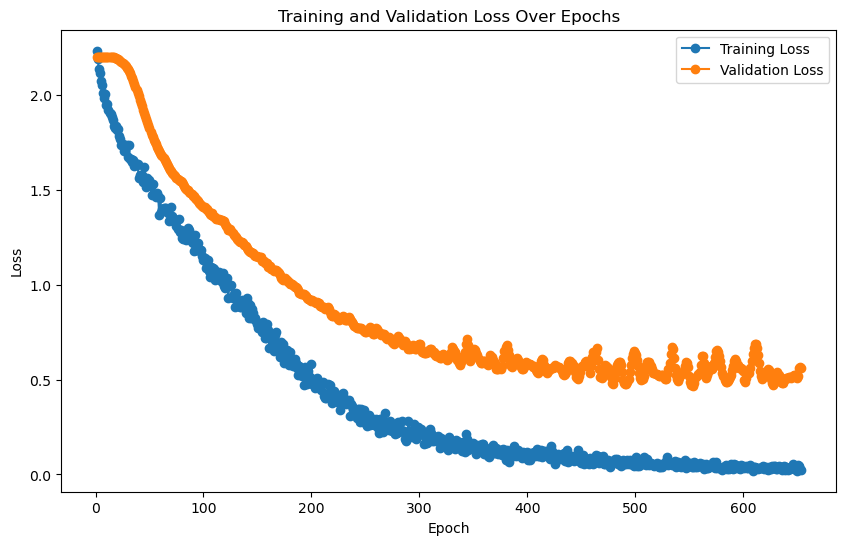

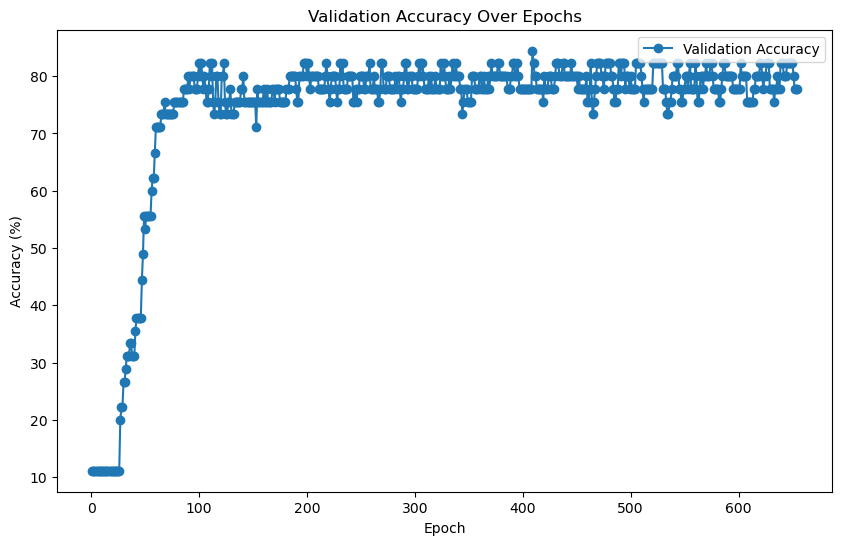


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.9062



Final Test Loss: 0.7964, Test Accuracy: 75.01%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42686, 64), Test labels shape: (42686,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.50      0.80      0.62         5
           2       0.67      0.40      0.50         5
           3       0.75      0.60      0.67         5
           4       1.00      0.80      0.89         5
           5       0.50      0.40      0.44         5
           6       0.67      0.80      0.73         5
           7       0.71      1.00      0.83         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42686, 64)
Test labels shape: (42686,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1905  |  Val Loss: 2.1578
Validation loss improved from inf to 2.1578.
[Epoch 2/1000] Train Loss: 2.0862  |  Val Loss: 2.0859
Validation loss improved from 2.1578 to 2.0859.
[Epoch 3/1000] Train Loss: 2.0117  |  Val Loss: 2.0311
Validation loss improved from 2.0859 to 2.0311.
[Epoch 4/1000] Train Loss: 1.9506  |  Val Loss: 1.9843
Validation loss improved from 2.0311 to 1.9843.
[Epoch 5/1000] Train Loss: 1.9015  |  Val Loss: 1.9442
Validation loss improved from 1.9843 to 1.9442.
[Epoch 6/1000] Train Loss: 1.8576  |  Val Loss: 1.9076
Validation loss improved from 1.9442 to 1.9076.
[Epoch 7/1000] Train Loss: 1.8150  |  Val Loss: 1.8741
Validation loss improved from 1.9076 to 1.8741.
[Epoch 8/1000] Train Loss: 1.7745  |  Val Loss: 1.8442
Validation loss improved from 1.8741 to 1.8442.
[Epoch 9/1000] Train Loss: 1.7366  |  Val Loss: 1.8135
Validation loss improved from 1.8442 to 1.8135.
[Epoch 10/1000] Train Loss: 1.7007  |  Val Loss: 1.7839
Validation loss impr

[Epoch 17/1000] Train Loss: 1.4612  |  Val Loss: 1.5671
Validation loss improved from 1.5958 to 1.5671.
[Epoch 18/1000] Train Loss: 1.4282  |  Val Loss: 1.5393
Validation loss improved from 1.5671 to 1.5393.
[Epoch 19/1000] Train Loss: 1.3954  |  Val Loss: 1.5113
Validation loss improved from 1.5393 to 1.5113.
[Epoch 20/1000] Train Loss: 1.3636  |  Val Loss: 1.4838
Validation loss improved from 1.5113 to 1.4838.
[Epoch 21/1000] Train Loss: 1.3319  |  Val Loss: 1.4571
Validation loss improved from 1.4838 to 1.4571.
[Epoch 22/1000] Train Loss: 1.2999  |  Val Loss: 1.4316
Validation loss improved from 1.4571 to 1.4316.
[Epoch 23/1000] Train Loss: 1.2681  |  Val Loss: 1.4074
Validation loss improved from 1.4316 to 1.4074.
[Epoch 24/1000] Train Loss: 1.2362  |  Val Loss: 1.3849
Validation loss improved from 1.4074 to 1.3849.
[Epoch 25/1000] Train Loss: 1.2051  |  Val Loss: 1.3632
Validation loss improved from 1.3849 to 1.3632.
[Epoch 26/1000] Train Loss: 1.1752  |  Val Loss: 1.3413
Validati

[Epoch 59/1000] Train Loss: 0.4686  |  Val Loss: 0.8846
Validation loss improved from 0.8933 to 0.8846.
[Epoch 60/1000] Train Loss: 0.4554  |  Val Loss: 0.8767
Validation loss improved from 0.8846 to 0.8767.
[Epoch 61/1000] Train Loss: 0.4427  |  Val Loss: 0.8695
Validation loss improved from 0.8767 to 0.8695.
[Epoch 62/1000] Train Loss: 0.4303  |  Val Loss: 0.8617
Validation loss improved from 0.8695 to 0.8617.
[Epoch 63/1000] Train Loss: 0.4182  |  Val Loss: 0.8536
Validation loss improved from 0.8617 to 0.8536.
[Epoch 64/1000] Train Loss: 0.4066  |  Val Loss: 0.8443
Validation loss improved from 0.8536 to 0.8443.
[Epoch 65/1000] Train Loss: 0.3951  |  Val Loss: 0.8349
Validation loss improved from 0.8443 to 0.8349.
[Epoch 66/1000] Train Loss: 0.3840  |  Val Loss: 0.8258
Validation loss improved from 0.8349 to 0.8258.
[Epoch 67/1000] Train Loss: 0.3733  |  Val Loss: 0.8181
Validation loss improved from 0.8258 to 0.8181.
[Epoch 68/1000] Train Loss: 0.3630  |  Val Loss: 0.8111
Validati

[Epoch 75/1000] Train Loss: 0.2967  |  Val Loss: 0.7613
Validation loss improved from 0.7680 to 0.7613.
[Epoch 76/1000] Train Loss: 0.2884  |  Val Loss: 0.7537
Validation loss improved from 0.7613 to 0.7537.
[Epoch 77/1000] Train Loss: 0.2802  |  Val Loss: 0.7457
Validation loss improved from 0.7537 to 0.7457.
[Epoch 78/1000] Train Loss: 0.2723  |  Val Loss: 0.7390
Validation loss improved from 0.7457 to 0.7390.
[Epoch 79/1000] Train Loss: 0.2648  |  Val Loss: 0.7336
Validation loss improved from 0.7390 to 0.7336.
[Epoch 80/1000] Train Loss: 0.2575  |  Val Loss: 0.7292
Validation loss improved from 0.7336 to 0.7292.
[Epoch 81/1000] Train Loss: 0.2503  |  Val Loss: 0.7247
Validation loss improved from 0.7292 to 0.7247.
[Epoch 82/1000] Train Loss: 0.2433  |  Val Loss: 0.7195
Validation loss improved from 0.7247 to 0.7195.
[Epoch 83/1000] Train Loss: 0.2365  |  Val Loss: 0.7136
Validation loss improved from 0.7195 to 0.7136.
[Epoch 84/1000] Train Loss: 0.2300  |  Val Loss: 0.7073
Validati

[Epoch 93/1000] Train Loss: 0.1803  |  Val Loss: 0.6781
Validation loss improved from 0.6795 to 0.6781.
[Epoch 94/1000] Train Loss: 0.1756  |  Val Loss: 0.6759
Validation loss improved from 0.6781 to 0.6759.
[Epoch 95/1000] Train Loss: 0.1711  |  Val Loss: 0.6730
Validation loss improved from 0.6759 to 0.6730.
[Epoch 96/1000] Train Loss: 0.1667  |  Val Loss: 0.6704
Validation loss improved from 0.6730 to 0.6704.
[Epoch 97/1000] Train Loss: 0.1625  |  Val Loss: 0.6675
Validation loss improved from 0.6704 to 0.6675.
[Epoch 98/1000] Train Loss: 0.1584  |  Val Loss: 0.6653
Validation loss improved from 0.6675 to 0.6653.
[Epoch 99/1000] Train Loss: 0.1545  |  Val Loss: 0.6633
Validation loss improved from 0.6653 to 0.6633.
[Epoch 100/1000] Train Loss: 0.1507  |  Val Loss: 0.6611
Validation loss improved from 0.6633 to 0.6611.
[Epoch 101/1000] Train Loss: 0.1470  |  Val Loss: 0.6602
Validation loss improved from 0.6611 to 0.6602.
[Epoch 102/1000] Train Loss: 0.1434  |  Val Loss: 0.6621
!! Va

[Epoch 133/1000] Train Loss: 0.0700  |  Val Loss: 0.7082
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 134/1000] Train Loss: 0.0684  |  Val Loss: 0.7097
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 135/1000] Train Loss: 0.0669  |  Val Loss: 0.7102
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 136/1000] Train Loss: 0.0654  |  Val Loss: 0.7122
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 137/1000] Train Loss: 0.0640  |  Val Loss: 0.7155
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 138/1000] Train Loss: 0.0625  |  Val Loss: 0.7201
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 139/1000] Train Loss: 0.0612  |  Val Loss: 0.7234
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 140/1000] Train Loss: 0.0598  |  Val Loss: 0.7267
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 141/1000] Train Loss: 0.0585  |  Val Loss: 0.7293
!! Validation loss did NOT improve !! Patience:

[Epoch 151/1000] Train Loss: 0.0471  |  Val Loss: 0.7530
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 152/1000] Train Loss: 0.0460  |  Val Loss: 0.7578
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 153/1000] Train Loss: 0.0450  |  Val Loss: 0.7632
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 154/1000] Train Loss: 0.0441  |  Val Loss: 0.7668
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 155/1000] Train Loss: 0.0432  |  Val Loss: 0.7682
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 156/1000] Train Loss: 0.0422  |  Val Loss: 0.7684
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 157/1000] Train Loss: 0.0413  |  Val Loss: 0.7692
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 158/1000] Train Loss: 0.0404  |  Val Loss: 0.7717
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 159/1000] Train Loss: 0.0396  |  Val Loss: 0.7758
!! Validation loss did NOT improve !! Patience:

[Epoch 170/1000] Train Loss: 0.0306  |  Val Loss: 0.8043
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 171/1000] Train Loss: 0.0299  |  Val Loss: 0.8056
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 172/1000] Train Loss: 0.0295  |  Val Loss: 0.8104
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 173/1000] Train Loss: 0.0287  |  Val Loss: 0.8167
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 174/1000] Train Loss: 0.0280  |  Val Loss: 0.8199
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 175/1000] Train Loss: 0.0274  |  Val Loss: 0.8190
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 176/1000] Train Loss: 0.0268  |  Val Loss: 0.8169
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 177/1000] Train Loss: 0.0262  |  Val Loss: 0.8168
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 178/1000] Train Loss: 0.0256  |  Val Loss: 0.8200
!! Validation loss did NOT improve !! Patience:

[Epoch 207/1000] Train Loss: 0.0143  |  Val Loss: 0.9192
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 208/1000] Train Loss: 0.0141  |  Val Loss: 0.9223
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 208 !!
No improvement for 100 epochs.


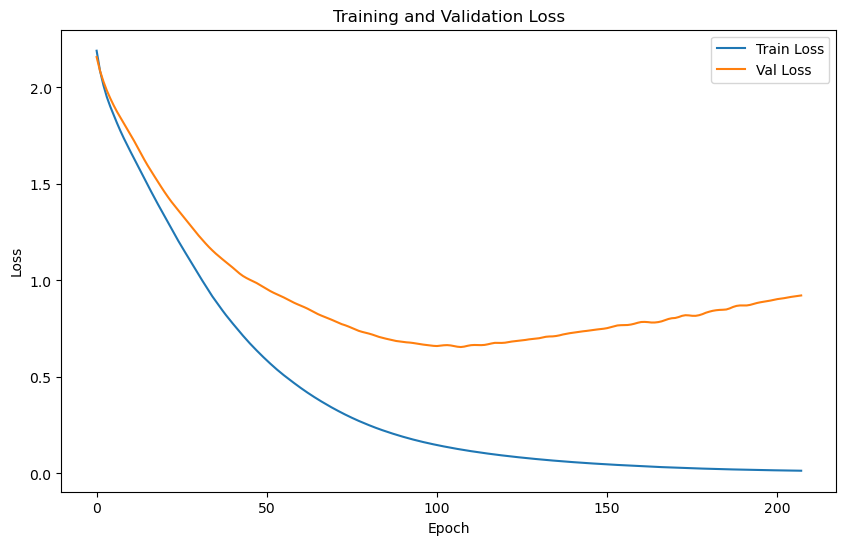

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.0795 | Test Accuracy: 61.69%


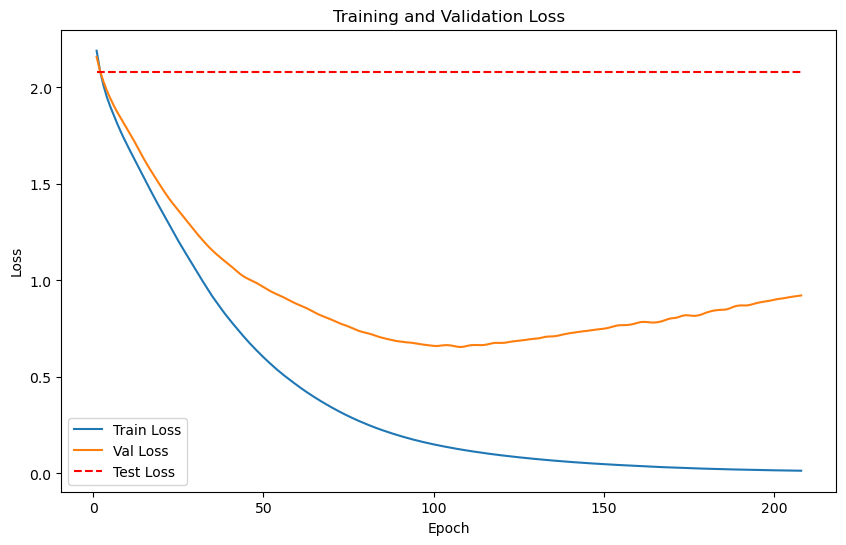

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.4676
Epoch [1/2000], Avg Train Loss: 8.4676
Epoch [1/2000], Avg Val Loss: 4.4240
Validation loss improved from inf to 4.4240. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.7467
Epoch [2/2000], Avg Train Loss: 8.7467
Epoch [2/2000], Avg Val Loss: 4.3853
Validation loss improved from 4.4240 to 4.3853. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.6266
Epoch [3/2000], Avg Train Loss: 8.6266
Epoch [3/2000], Avg Val Loss: 4.3470
Validation loss improved from 4.3853 to 4.3470. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.5870
Epoch [4/2000], Avg Train Loss: 8.5870
Epoch [4/2000], Avg Val Loss: 4.3087
Validation loss improved from 4.3470 to 4.3087. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7678
Epoch [5/2000], Avg Train Loss: 8.7678
Epoch [5/2000], Avg Val Loss: 4.2715
Validation loss improved from 4.3087 to 4.2715. Saving mode

Epoch [10/2000], Avg Val Loss: 4.0973
Validation loss improved from 4.1306 to 4.0973. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 8.3741
Epoch [11/2000], Avg Train Loss: 8.3741
Epoch [11/2000], Avg Val Loss: 4.0644
Validation loss improved from 4.0973 to 4.0644. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.3452
Epoch [12/2000], Avg Train Loss: 8.3452
Epoch [12/2000], Avg Val Loss: 4.0322
Validation loss improved from 4.0644 to 4.0322. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.4391
Epoch [13/2000], Avg Train Loss: 7.4391
Epoch [13/2000], Avg Val Loss: 4.0009
Validation loss improved from 4.0322 to 4.0009. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.6866
Epoch [14/2000], Avg Train Loss: 7.6866
Epoch [14/2000], Avg Val Loss: 3.9702
Validation loss improved from 4.0009 to 3.9702. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.7717
Epoch [30/2000], Avg Train Loss: 6.7717
Epoch [30/2000], Avg Val Loss: 3.5601
Validation loss improved from 3.5818 to 3.5601. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.9771
Epoch [31/2000], Avg Train Loss: 6.9771
Epoch [31/2000], Avg Val Loss: 3.5388
Validation loss improved from 3.5601 to 3.5388. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.5504
Epoch [32/2000], Avg Train Loss: 6.5504
Epoch [32/2000], Avg Val Loss: 3.5180
Validation loss improved from 3.5388 to 3.5180. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.6958
Epoch [33/2000], Avg Train Loss: 6.6958
Epoch [33/2000], Avg Val Loss: 3.4977
Validation loss improved from 3.5180 to 3.4977. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.5847
Epoch [34/2000], Avg Train Loss: 6.5847
Epoch [34/2000], Avg Val Loss: 3.4779
Validation loss improved from 3.4977 to 3.

Epoch [51/2000], Avg Val Loss: 3.2108
Validation loss improved from 3.2234 to 3.2108. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.1081
Epoch [52/2000], Avg Train Loss: 6.1081
Epoch [52/2000], Avg Val Loss: 3.1985
Validation loss improved from 3.2108 to 3.1985. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.7102
Epoch [53/2000], Avg Train Loss: 5.7102
Epoch [53/2000], Avg Val Loss: 3.1865
Validation loss improved from 3.1985 to 3.1865. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.5204
Epoch [54/2000], Avg Train Loss: 5.5204
Epoch [54/2000], Avg Val Loss: 3.1749
Validation loss improved from 3.1865 to 3.1749. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.8765
Epoch [55/2000], Avg Train Loss: 5.8765
Epoch [55/2000], Avg Val Loss: 3.1635
Validation loss improved from 3.1749 to 3.1635. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Trai

Epoch [59/2000], Avg Val Loss: 3.1210
Validation loss improved from 3.1311 to 3.1210. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.6248
Epoch [60/2000], Avg Train Loss: 5.6248
Epoch [60/2000], Avg Val Loss: 3.1112
Validation loss improved from 3.1210 to 3.1112. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.5383
Epoch [61/2000], Avg Train Loss: 5.5383
Epoch [61/2000], Avg Val Loss: 3.1018
Validation loss improved from 3.1112 to 3.1018. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6167
Epoch [62/2000], Avg Train Loss: 5.6167
Epoch [62/2000], Avg Val Loss: 3.0924
Validation loss improved from 3.1018 to 3.0924. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.4869
Epoch [63/2000], Avg Train Loss: 5.4869
Epoch [63/2000], Avg Val Loss: 3.0834
Validation loss improved from 3.0924 to 3.0834. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9600
Epoch [77/2000], Avg Train Loss: 4.9600
Epoch [77/2000], Avg Val Loss: 2.9797
Validation loss improved from 2.9858 to 2.9797. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.9827
Epoch [78/2000], Avg Train Loss: 4.9827
Epoch [78/2000], Avg Val Loss: 2.9737
Validation loss improved from 2.9797 to 2.9737. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 4.7863
Epoch [79/2000], Avg Train Loss: 4.7863
Epoch [79/2000], Avg Val Loss: 2.9680
Validation loss improved from 2.9737 to 2.9680. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.8728
Epoch [80/2000], Avg Train Loss: 4.8728
Epoch [80/2000], Avg Val Loss: 2.9623
Validation loss improved from 2.9680 to 2.9623. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.6062
Epoch [81/2000], Avg Train Loss: 4.6062
Epoch [81/2000], Avg Val Loss: 2.9570
Validation loss improved from 2.9623 to 2.

Epoch [100/2000], Avg Val Loss: 2.8830
Validation loss improved from 2.8859 to 2.8830. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.5174
Epoch [101/2000], Avg Train Loss: 4.5174
Epoch [101/2000], Avg Val Loss: 2.8801
Validation loss improved from 2.8830 to 2.8801. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.3854
Epoch [102/2000], Avg Train Loss: 4.3854
Epoch [102/2000], Avg Val Loss: 2.8773
Validation loss improved from 2.8801 to 2.8773. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.3693
Epoch [103/2000], Avg Train Loss: 4.3693
Epoch [103/2000], Avg Val Loss: 2.8746
Validation loss improved from 2.8773 to 2.8746. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.3225
Epoch [104/2000], Avg Train Loss: 4.3225
Epoch [104/2000], Avg Val Loss: 2.8720
Validation loss improved from 2.8746 to 2.8720. Saving model...

LOG: Epoch [105/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0427
Epoch [122/2000], Avg Train Loss: 4.0427
Epoch [122/2000], Avg Val Loss: 2.8359
Validation loss improved from 2.8374 to 2.8359. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.1804
Epoch [123/2000], Avg Train Loss: 4.1804
Epoch [123/2000], Avg Val Loss: 2.8344
Validation loss improved from 2.8359 to 2.8344. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 3.9380
Epoch [124/2000], Avg Train Loss: 3.9380
Epoch [124/2000], Avg Val Loss: 2.8330
Validation loss improved from 2.8344 to 2.8330. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.1723
Epoch [125/2000], Avg Train Loss: 4.1723
Epoch [125/2000], Avg Val Loss: 2.8316
Validation loss improved from 2.8330 to 2.8316. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.1937
Epoch [126/2000], Avg Train Loss: 4.1937
Epoch [126/2000], Avg Val Loss: 2.8303
Validation loss improved fro

Epoch [143/2000], Avg Val Loss: 2.8130
Validation loss improved from 2.8139 to 2.8130. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 3.8565
Epoch [144/2000], Avg Train Loss: 3.8565
Epoch [144/2000], Avg Val Loss: 2.8122
Validation loss improved from 2.8130 to 2.8122. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 3.7549
Epoch [145/2000], Avg Train Loss: 3.7549
Epoch [145/2000], Avg Val Loss: 2.8114
Validation loss improved from 2.8122 to 2.8114. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 3.9368
Epoch [146/2000], Avg Train Loss: 3.9368
Epoch [146/2000], Avg Val Loss: 2.8106
Validation loss improved from 2.8114 to 2.8106. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.7052
Epoch [147/2000], Avg Train Loss: 3.7052
Epoch [147/2000], Avg Val Loss: 2.8098
Validation loss improved from 2.8106 to 2.8098. Saving model...

LOG: Epoch [148/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6413
Epoch [172/2000], Avg Train Loss: 3.6413
Epoch [172/2000], Avg Val Loss: 2.7939
Validation loss improved from 2.7944 to 2.7939. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 3.7115
Epoch [173/2000], Avg Train Loss: 3.7115
Epoch [173/2000], Avg Val Loss: 2.7934
Validation loss improved from 2.7939 to 2.7934. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 3.6190
Epoch [174/2000], Avg Train Loss: 3.6190
Epoch [174/2000], Avg Val Loss: 2.7929
Validation loss improved from 2.7934 to 2.7929. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 3.5289
Epoch [175/2000], Avg Train Loss: 3.5289
Epoch [175/2000], Avg Val Loss: 2.7924
Validation loss improved from 2.7929 to 2.7924. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 3.4904
Epoch [176/2000], Avg Train Loss: 3.4904
Epoch [176/2000], Avg Val Loss: 2.7919
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4484
Epoch [193/2000], Avg Train Loss: 3.4484
Epoch [193/2000], Avg Val Loss: 2.7843
Validation loss improved from 2.7847 to 2.7843. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.2930
Epoch [194/2000], Avg Train Loss: 3.2930
Epoch [194/2000], Avg Val Loss: 2.7839
Validation loss improved from 2.7843 to 2.7839. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.4332
Epoch [195/2000], Avg Train Loss: 3.4332
Epoch [195/2000], Avg Val Loss: 2.7835
Validation loss improved from 2.7839 to 2.7835. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.4035
Epoch [196/2000], Avg Train Loss: 3.4035
Epoch [196/2000], Avg Val Loss: 2.7831
Validation loss improved from 2.7835 to 2.7831. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.4440
Epoch [197/2000], Avg Train Loss: 3.4440
Epoch [197/2000], Avg Val Loss: 2.7827
Validation loss improved fro

Epoch [221/2000], Avg Val Loss: 2.7747
Validation loss improved from 2.7751 to 2.7747. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.2164
Epoch [222/2000], Avg Train Loss: 3.2164
Epoch [222/2000], Avg Val Loss: 2.7744
Validation loss improved from 2.7747 to 2.7744. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.1997
Epoch [223/2000], Avg Train Loss: 3.1997
Epoch [223/2000], Avg Val Loss: 2.7740
Validation loss improved from 2.7744 to 2.7740. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.4599
Epoch [224/2000], Avg Train Loss: 3.4599
Epoch [224/2000], Avg Val Loss: 2.7737
Validation loss improved from 2.7740 to 2.7737. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 3.2618
Epoch [225/2000], Avg Train Loss: 3.2618
Epoch [225/2000], Avg Val Loss: 2.7733
Validation loss improved from 2.7737 to 2.7733. Saving model...

LOG: Epoch [226/2000] - Training
    Bat

Epoch [242/2000], Avg Val Loss: 2.7670
Validation loss improved from 2.7673 to 2.7670. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 3.3240
Epoch [243/2000], Avg Train Loss: 3.3240
Epoch [243/2000], Avg Val Loss: 2.7666
Validation loss improved from 2.7670 to 2.7666. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 3.2478
Epoch [244/2000], Avg Train Loss: 3.2478
Epoch [244/2000], Avg Val Loss: 2.7663
Validation loss improved from 2.7666 to 2.7663. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 3.3699
Epoch [245/2000], Avg Train Loss: 3.3699
Epoch [245/2000], Avg Val Loss: 2.7659
Validation loss improved from 2.7663 to 2.7659. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.1819
Epoch [246/2000], Avg Train Loss: 3.1819
Epoch [246/2000], Avg Val Loss: 2.7655
Validation loss improved from 2.7659 to 2.7655. Saving model...

LOG: Epoch [247/2000] - Training
    Bat

Epoch [270/2000], Avg Val Loss: 2.7539
Validation loss improved from 2.7544 to 2.7539. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 3.2017
Epoch [271/2000], Avg Train Loss: 3.2017
Epoch [271/2000], Avg Val Loss: 2.7534
Validation loss improved from 2.7539 to 2.7534. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 3.0977
Epoch [272/2000], Avg Train Loss: 3.0977
Epoch [272/2000], Avg Val Loss: 2.7529
Validation loss improved from 2.7534 to 2.7529. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 3.2586
Epoch [273/2000], Avg Train Loss: 3.2586
Epoch [273/2000], Avg Val Loss: 2.7524
Validation loss improved from 2.7529 to 2.7524. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 3.3617
Epoch [274/2000], Avg Train Loss: 3.3617
Epoch [274/2000], Avg Val Loss: 2.7519
Validation loss improved from 2.7524 to 2.7519. Saving model...

LOG: Epoch [275/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1421
Epoch [297/2000], Avg Train Loss: 3.1421
Epoch [297/2000], Avg Val Loss: 2.7399
Validation loss improved from 2.7404 to 2.7399. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.0822
Epoch [298/2000], Avg Train Loss: 3.0822
Epoch [298/2000], Avg Val Loss: 2.7394
Validation loss improved from 2.7399 to 2.7394. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.1184
Epoch [299/2000], Avg Train Loss: 3.1184
Epoch [299/2000], Avg Val Loss: 2.7389
Validation loss improved from 2.7394 to 2.7389. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.1047
Epoch [300/2000], Avg Train Loss: 3.1047
Epoch [300/2000], Avg Val Loss: 2.7384
Validation loss improved from 2.7389 to 2.7384. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.1265
Epoch [301/2000], Avg Train Loss: 3.1265
Epoch [301/2000], Avg Val Loss: 2.7379
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9998
Epoch [322/2000], Avg Train Loss: 2.9998
Epoch [322/2000], Avg Val Loss: 2.7259
Validation loss improved from 2.7264 to 2.7259. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.0214
Epoch [323/2000], Avg Train Loss: 3.0214
Epoch [323/2000], Avg Val Loss: 2.7253
Validation loss improved from 2.7259 to 2.7253. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 3.0283
Epoch [324/2000], Avg Train Loss: 3.0283
Epoch [324/2000], Avg Val Loss: 2.7248
Validation loss improved from 2.7253 to 2.7248. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 2.9849
Epoch [325/2000], Avg Train Loss: 2.9849
Epoch [325/2000], Avg Val Loss: 2.7242
Validation loss improved from 2.7248 to 2.7242. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.0278
Epoch [326/2000], Avg Train Loss: 3.0278
Epoch [326/2000], Avg Val Loss: 2.7236
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9231
Epoch [345/2000], Avg Train Loss: 2.9231
Epoch [345/2000], Avg Val Loss: 2.7127
Validation loss improved from 2.7133 to 2.7127. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.0184
Epoch [346/2000], Avg Train Loss: 3.0184
Epoch [346/2000], Avg Val Loss: 2.7122
Validation loss improved from 2.7127 to 2.7122. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.0348
Epoch [347/2000], Avg Train Loss: 3.0348
Epoch [347/2000], Avg Val Loss: 2.7117
Validation loss improved from 2.7122 to 2.7117. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.0238
Epoch [348/2000], Avg Train Loss: 3.0238
Epoch [348/2000], Avg Val Loss: 2.7112
Validation loss improved from 2.7117 to 2.7112. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 2.9363
Epoch [349/2000], Avg Train Loss: 2.9363
Epoch [349/2000], Avg Val Loss: 2.7106
Validation loss improved fro

Epoch [370/2000], Avg Val Loss: 2.6980
Validation loss improved from 2.6986 to 2.6980. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.0061
Epoch [371/2000], Avg Train Loss: 3.0061
Epoch [371/2000], Avg Val Loss: 2.6974
Validation loss improved from 2.6980 to 2.6974. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.0529
Epoch [372/2000], Avg Train Loss: 3.0529
Epoch [372/2000], Avg Val Loss: 2.6968
Validation loss improved from 2.6974 to 2.6968. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 2.9215
Epoch [373/2000], Avg Train Loss: 2.9215
Epoch [373/2000], Avg Val Loss: 2.6962
Validation loss improved from 2.6968 to 2.6962. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 2.9645
Epoch [374/2000], Avg Train Loss: 2.9645
Epoch [374/2000], Avg Val Loss: 2.6956
Validation loss improved from 2.6962 to 2.6956. Saving model...

LOG: Epoch [375/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9892
Epoch [389/2000], Avg Train Loss: 2.9892
Epoch [389/2000], Avg Val Loss: 2.6863
Validation loss improved from 2.6870 to 2.6863. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 2.8201
Epoch [390/2000], Avg Train Loss: 2.8201
Epoch [390/2000], Avg Val Loss: 2.6856
Validation loss improved from 2.6863 to 2.6856. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 2.9306
Epoch [391/2000], Avg Train Loss: 2.9306
Epoch [391/2000], Avg Val Loss: 2.6850
Validation loss improved from 2.6856 to 2.6850. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.0376
Epoch [392/2000], Avg Train Loss: 3.0376
Epoch [392/2000], Avg Val Loss: 2.6844
Validation loss improved from 2.6850 to 2.6844. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 2.8741
Epoch [393/2000], Avg Train Loss: 2.8741
Epoch [393/2000], Avg Val Loss: 2.6838
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8993
Epoch [419/2000], Avg Train Loss: 2.8993
Epoch [419/2000], Avg Val Loss: 2.6686
Validation loss improved from 2.6691 to 2.6686. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 2.8453
Epoch [420/2000], Avg Train Loss: 2.8453
Epoch [420/2000], Avg Val Loss: 2.6680
Validation loss improved from 2.6686 to 2.6680. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 2.7977
Epoch [421/2000], Avg Train Loss: 2.7977
Epoch [421/2000], Avg Val Loss: 2.6675
Validation loss improved from 2.6680 to 2.6675. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 2.9195
Epoch [422/2000], Avg Train Loss: 2.9195
Epoch [422/2000], Avg Val Loss: 2.6670
Validation loss improved from 2.6675 to 2.6670. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 2.8250
Epoch [423/2000], Avg Train Loss: 2.8250
Epoch [423/2000], Avg Val Loss: 2.6665
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9135
Epoch [443/2000], Avg Train Loss: 2.9135
Epoch [443/2000], Avg Val Loss: 2.6567
Validation loss improved from 2.6571 to 2.6567. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 2.7627
Epoch [444/2000], Avg Train Loss: 2.7627
Epoch [444/2000], Avg Val Loss: 2.6562
Validation loss improved from 2.6567 to 2.6562. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 2.7786
Epoch [445/2000], Avg Train Loss: 2.7786
Epoch [445/2000], Avg Val Loss: 2.6557
Validation loss improved from 2.6562 to 2.6557. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 2.8579
Epoch [446/2000], Avg Train Loss: 2.8579
Epoch [446/2000], Avg Val Loss: 2.6552
Validation loss improved from 2.6557 to 2.6552. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 2.8829
Epoch [447/2000], Avg Train Loss: 2.8829
Epoch [447/2000], Avg Val Loss: 2.6547
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7951
Epoch [469/2000], Avg Train Loss: 2.7951
Epoch [469/2000], Avg Val Loss: 2.6439
Validation loss improved from 2.6444 to 2.6439. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 2.8577
Epoch [470/2000], Avg Train Loss: 2.8577
Epoch [470/2000], Avg Val Loss: 2.6434
Validation loss improved from 2.6439 to 2.6434. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 2.7692
Epoch [471/2000], Avg Train Loss: 2.7692
Epoch [471/2000], Avg Val Loss: 2.6430
Validation loss improved from 2.6434 to 2.6430. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 2.8380
Epoch [472/2000], Avg Train Loss: 2.8380
Epoch [472/2000], Avg Val Loss: 2.6425
Validation loss improved from 2.6430 to 2.6425. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 2.7029
Epoch [473/2000], Avg Train Loss: 2.7029
Epoch [473/2000], Avg Val Loss: 2.6421
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7492
Epoch [487/2000], Avg Train Loss: 2.7492
Epoch [487/2000], Avg Val Loss: 2.6356
Validation loss improved from 2.6361 to 2.6356. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 2.7060
Epoch [488/2000], Avg Train Loss: 2.7060
Epoch [488/2000], Avg Val Loss: 2.6352
Validation loss improved from 2.6356 to 2.6352. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 2.7038
Epoch [489/2000], Avg Train Loss: 2.7038
Epoch [489/2000], Avg Val Loss: 2.6348
Validation loss improved from 2.6352 to 2.6348. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 2.8034
Epoch [490/2000], Avg Train Loss: 2.8034
Epoch [490/2000], Avg Val Loss: 2.6344
Validation loss improved from 2.6348 to 2.6344. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 2.6779
Epoch [491/2000], Avg Train Loss: 2.6779
Epoch [491/2000], Avg Val Loss: 2.6339
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7763
Epoch [513/2000], Avg Train Loss: 2.7763
Epoch [513/2000], Avg Val Loss: 2.6245
Validation loss improved from 2.6249 to 2.6245. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 2.7881
Epoch [514/2000], Avg Train Loss: 2.7881
Epoch [514/2000], Avg Val Loss: 2.6241
Validation loss improved from 2.6245 to 2.6241. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 2.6785
Epoch [515/2000], Avg Train Loss: 2.6785
Epoch [515/2000], Avg Val Loss: 2.6237
Validation loss improved from 2.6241 to 2.6237. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 2.6735
Epoch [516/2000], Avg Train Loss: 2.6735
Epoch [516/2000], Avg Val Loss: 2.6233
Validation loss improved from 2.6237 to 2.6233. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 2.7173
Epoch [517/2000], Avg Train Loss: 2.7173
Epoch [517/2000], Avg Val Loss: 2.6228
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6526
Epoch [534/2000], Avg Train Loss: 2.6526
Epoch [534/2000], Avg Val Loss: 2.6146
Validation loss improved from 2.6150 to 2.6146. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 2.7487
Epoch [535/2000], Avg Train Loss: 2.7487
Epoch [535/2000], Avg Val Loss: 2.6142
Validation loss improved from 2.6146 to 2.6142. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 2.6850
Epoch [536/2000], Avg Train Loss: 2.6850
Epoch [536/2000], Avg Val Loss: 2.6138
Validation loss improved from 2.6142 to 2.6138. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 2.6688
Epoch [537/2000], Avg Train Loss: 2.6688
Epoch [537/2000], Avg Val Loss: 2.6134
Validation loss improved from 2.6138 to 2.6134. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 2.7263
Epoch [538/2000], Avg Train Loss: 2.7263
Epoch [538/2000], Avg Val Loss: 2.6130
Validation loss improved fro

Epoch [562/2000], Avg Val Loss: 2.6030
Validation loss improved from 2.6034 to 2.6030. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 2.6604
Epoch [563/2000], Avg Train Loss: 2.6604
Epoch [563/2000], Avg Val Loss: 2.6026
Validation loss improved from 2.6030 to 2.6026. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 2.6564
Epoch [564/2000], Avg Train Loss: 2.6564
Epoch [564/2000], Avg Val Loss: 2.6022
Validation loss improved from 2.6026 to 2.6022. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 2.5873
Epoch [565/2000], Avg Train Loss: 2.5873
Epoch [565/2000], Avg Val Loss: 2.6018
Validation loss improved from 2.6022 to 2.6018. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 2.6271
Epoch [566/2000], Avg Train Loss: 2.6271
Epoch [566/2000], Avg Val Loss: 2.6015
Validation loss improved from 2.6018 to 2.6015. Saving model...

LOG: Epoch [567/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6736
Epoch [580/2000], Avg Train Loss: 2.6736
Epoch [580/2000], Avg Val Loss: 2.5965
Validation loss improved from 2.5969 to 2.5965. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 2.5953
Epoch [581/2000], Avg Train Loss: 2.5953
Epoch [581/2000], Avg Val Loss: 2.5962
Validation loss improved from 2.5965 to 2.5962. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 2.6574
Epoch [582/2000], Avg Train Loss: 2.6574
Epoch [582/2000], Avg Val Loss: 2.5958
Validation loss improved from 2.5962 to 2.5958. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 2.6801
Epoch [583/2000], Avg Train Loss: 2.6801
Epoch [583/2000], Avg Val Loss: 2.5955
Validation loss improved from 2.5958 to 2.5955. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 2.6008
Epoch [584/2000], Avg Train Loss: 2.6008
Epoch [584/2000], Avg Val Loss: 2.5951
Validation loss improved fro

Epoch [606/2000], Avg Val Loss: 2.5882
Validation loss improved from 2.5884 to 2.5882. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 2.5608
Epoch [607/2000], Avg Train Loss: 2.5608
Epoch [607/2000], Avg Val Loss: 2.5879
Validation loss improved from 2.5882 to 2.5879. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 2.6134
Epoch [608/2000], Avg Train Loss: 2.6134
Epoch [608/2000], Avg Val Loss: 2.5876
Validation loss improved from 2.5879 to 2.5876. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 2.6004
Epoch [609/2000], Avg Train Loss: 2.6004
Epoch [609/2000], Avg Val Loss: 2.5874
Validation loss improved from 2.5876 to 2.5874. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 2.6328
Epoch [610/2000], Avg Train Loss: 2.6328
Epoch [610/2000], Avg Val Loss: 2.5871
Validation loss improved from 2.5874 to 2.5871. Saving model...

LOG: Epoch [611/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5476
Epoch [626/2000], Avg Train Loss: 2.5476
Epoch [626/2000], Avg Val Loss: 2.5842
Validation loss improved from 2.5844 to 2.5842. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 2.7095
Epoch [627/2000], Avg Train Loss: 2.7095
Epoch [627/2000], Avg Val Loss: 2.5840
Validation loss improved from 2.5842 to 2.5840. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 2.5877
Epoch [628/2000], Avg Train Loss: 2.5877
Epoch [628/2000], Avg Val Loss: 2.5838
Validation loss improved from 2.5840 to 2.5838. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 2.6282
Epoch [629/2000], Avg Train Loss: 2.6282
Epoch [629/2000], Avg Val Loss: 2.5836
Validation loss improved from 2.5838 to 2.5836. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 2.5408
Epoch [630/2000], Avg Train Loss: 2.5408
Epoch [630/2000], Avg Val Loss: 2.5834
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6063
Epoch [655/2000], Avg Train Loss: 2.6063
Epoch [655/2000], Avg Val Loss: 2.5759
Validation loss improved from 2.5763 to 2.5759. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 2.5944
Epoch [656/2000], Avg Train Loss: 2.5944
Epoch [656/2000], Avg Val Loss: 2.5756
Validation loss improved from 2.5759 to 2.5756. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 2.5955
Epoch [657/2000], Avg Train Loss: 2.5955
Epoch [657/2000], Avg Val Loss: 2.5752
Validation loss improved from 2.5756 to 2.5752. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 2.5481
Epoch [658/2000], Avg Train Loss: 2.5481
Epoch [658/2000], Avg Val Loss: 2.5748
Validation loss improved from 2.5752 to 2.5748. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 2.5076
Epoch [659/2000], Avg Train Loss: 2.5076
Epoch [659/2000], Avg Val Loss: 2.5745
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5256
Epoch [668/2000], Avg Train Loss: 2.5256
Epoch [668/2000], Avg Val Loss: 2.5719
Validation loss improved from 2.5722 to 2.5719. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 2.4944
Epoch [669/2000], Avg Train Loss: 2.4944
Epoch [669/2000], Avg Val Loss: 2.5717
Validation loss improved from 2.5719 to 2.5717. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 2.5552
Epoch [670/2000], Avg Train Loss: 2.5552
Epoch [670/2000], Avg Val Loss: 2.5715
Validation loss improved from 2.5717 to 2.5715. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 2.5006
Epoch [671/2000], Avg Train Loss: 2.5006
Epoch [671/2000], Avg Val Loss: 2.5712
Validation loss improved from 2.5715 to 2.5712. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 2.5282
Epoch [672/2000], Avg Train Loss: 2.5282
Epoch [672/2000], Avg Val Loss: 2.5709
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5605
Epoch [701/2000], Avg Train Loss: 2.5605
Epoch [701/2000], Avg Val Loss: 2.5645
Validation loss improved from 2.5647 to 2.5645. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 2.4559
Epoch [702/2000], Avg Train Loss: 2.4559
Epoch [702/2000], Avg Val Loss: 2.5643
Validation loss improved from 2.5645 to 2.5643. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 2.4987
Epoch [703/2000], Avg Train Loss: 2.4987
Epoch [703/2000], Avg Val Loss: 2.5641
Validation loss improved from 2.5643 to 2.5641. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 2.5414
Epoch [704/2000], Avg Train Loss: 2.5414
Epoch [704/2000], Avg Val Loss: 2.5639
Validation loss improved from 2.5641 to 2.5639. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 2.4892
Epoch [705/2000], Avg Train Loss: 2.4892
Epoch [705/2000], Avg Val Loss: 2.5637
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5883
Epoch [712/2000], Avg Train Loss: 2.5883
Epoch [712/2000], Avg Val Loss: 2.5621
Validation loss improved from 2.5622 to 2.5621. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 2.4706
Epoch [713/2000], Avg Train Loss: 2.4706
Epoch [713/2000], Avg Val Loss: 2.5619
Validation loss improved from 2.5621 to 2.5619. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 2.5008
Epoch [714/2000], Avg Train Loss: 2.5008
Epoch [714/2000], Avg Val Loss: 2.5617
Validation loss improved from 2.5619 to 2.5617. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 2.4970
Epoch [715/2000], Avg Train Loss: 2.4970
Epoch [715/2000], Avg Val Loss: 2.5615
Validation loss improved from 2.5617 to 2.5615. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 2.5077
Epoch [716/2000], Avg Train Loss: 2.5077
Epoch [716/2000], Avg Val Loss: 2.5613
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4715
Epoch [752/2000], Avg Train Loss: 2.4715
Epoch [752/2000], Avg Val Loss: 2.5541
Validation loss improved from 2.5543 to 2.5541. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 2.4502
Epoch [753/2000], Avg Train Loss: 2.4502
Epoch [753/2000], Avg Val Loss: 2.5539
Validation loss improved from 2.5541 to 2.5539. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 2.4945
Epoch [754/2000], Avg Train Loss: 2.4945
Epoch [754/2000], Avg Val Loss: 2.5537
Validation loss improved from 2.5539 to 2.5537. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 2.4737
Epoch [755/2000], Avg Train Loss: 2.4737
Epoch [755/2000], Avg Val Loss: 2.5535
Validation loss improved from 2.5537 to 2.5535. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 2.5100
Epoch [756/2000], Avg Train Loss: 2.5100
Epoch [756/2000], Avg Val Loss: 2.5533
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4253
Epoch [764/2000], Avg Train Loss: 2.4253
Epoch [764/2000], Avg Val Loss: 2.5521
Validation loss improved from 2.5522 to 2.5521. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 2.3911
Epoch [765/2000], Avg Train Loss: 2.3911
Epoch [765/2000], Avg Val Loss: 2.5520
Validation loss improved from 2.5521 to 2.5520. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 2.4936
Epoch [766/2000], Avg Train Loss: 2.4936
Epoch [766/2000], Avg Val Loss: 2.5520
Validation loss improved from 2.5520 to 2.5520. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 2.4346
Epoch [767/2000], Avg Train Loss: 2.4346
Epoch [767/2000], Avg Val Loss: 2.5519
Validation loss improved from 2.5520 to 2.5519. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 2.4373
Epoch [768/2000], Avg Train Loss: 2.4373
Epoch [768/2000], Avg Val Loss: 2.5517
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4771
Epoch [800/2000], Avg Train Loss: 2.4771
Epoch [800/2000], Avg Val Loss: 2.5485
Validation loss improved from 2.5486 to 2.5485. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 2.4191
Epoch [801/2000], Avg Train Loss: 2.4191
Epoch [801/2000], Avg Val Loss: 2.5485
Validation loss improved from 2.5485 to 2.5485. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 2.3822
Epoch [802/2000], Avg Train Loss: 2.3822
Epoch [802/2000], Avg Val Loss: 2.5484
Validation loss improved from 2.5485 to 2.5484. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 2.4435
Epoch [803/2000], Avg Train Loss: 2.4435
Epoch [803/2000], Avg Val Loss: 2.5484
Validation loss improved from 2.5484 to 2.5484. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 2.4417
Epoch [804/2000], Avg Train Loss: 2.4417
Epoch [804/2000], Avg Val Loss: 2.5483
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4689
Epoch [814/2000], Avg Train Loss: 2.4689
Epoch [814/2000], Avg Val Loss: 2.5477
Validation loss improved from 2.5478 to 2.5477. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 2.4686
Epoch [815/2000], Avg Train Loss: 2.4686
Epoch [815/2000], Avg Val Loss: 2.5477
Validation loss improved from 2.5477 to 2.5477. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 2.4822
Epoch [816/2000], Avg Train Loss: 2.4822
Epoch [816/2000], Avg Val Loss: 2.5475
Validation loss improved from 2.5477 to 2.5475. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 2.4585
Epoch [817/2000], Avg Train Loss: 2.4585
Epoch [817/2000], Avg Val Loss: 2.5474
Validation loss improved from 2.5475 to 2.5474. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 2.3580
Epoch [818/2000], Avg Train Loss: 2.3580
Epoch [818/2000], Avg Val Loss: 2.5473
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3365
Epoch [849/2000], Avg Train Loss: 2.3365
Epoch [849/2000], Avg Val Loss: 2.5456
Validation loss did not improve. Patience: 10/100

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 2.3351
Epoch [850/2000], Avg Train Loss: 2.3351
Epoch [850/2000], Avg Val Loss: 2.5456
Validation loss did not improve. Patience: 11/100

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 2.3477
Epoch [851/2000], Avg Train Loss: 2.3477
Epoch [851/2000], Avg Val Loss: 2.5456
Validation loss did not improve. Patience: 12/100

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 2.4166
Epoch [852/2000], Avg Train Loss: 2.4166
Epoch [852/2000], Avg Val Loss: 2.5455
Validation loss did not improve. Patience: 13/100

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 2.3814
Epoch [853/2000], Avg Train Loss: 2.3814
Epoch [853/2000], Avg Val Loss: 2.5454
Validation loss did not improve. Patience: 14/100

LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 2.4308
Epoch [863/2000], Avg Train Loss: 2.4308
Epoch [863/2000], Avg Val Loss: 2.5445
Validation loss improved from 2.5446 to 2.5445. Saving model...

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 2.4341
Epoch [864/2000], Avg Train Loss: 2.4341
Epoch [864/2000], Avg Val Loss: 2.5444
Validation loss improved from 2.5445 to 2.5444. Saving model...

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 2.4038
Epoch [865/2000], Avg Train Loss: 2.4038
Epoch [865/2000], Avg Val Loss: 2.5444
Validation loss improved from 2.5444 to 2.5444. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 2.3815
Epoch [866/2000], Avg Train Loss: 2.3815
Epoch [866/2000], Avg Val Loss: 2.5442
Validation loss improved from 2.5444 to 2.5442. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 2.4736
Epoch [867/2000], Avg Train Loss: 2.4736
Epoch [867/2000], Avg Val Loss: 2.5441
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3585
Epoch [896/2000], Avg Train Loss: 2.3585
Epoch [896/2000], Avg Val Loss: 2.5422
Validation loss improved from 2.5423 to 2.5422. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 2.3892
Epoch [897/2000], Avg Train Loss: 2.3892
Epoch [897/2000], Avg Val Loss: 2.5421
Validation loss improved from 2.5422 to 2.5421. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 2.3789
Epoch [898/2000], Avg Train Loss: 2.3789
Epoch [898/2000], Avg Val Loss: 2.5420
Validation loss improved from 2.5421 to 2.5420. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.4143
Epoch [899/2000], Avg Train Loss: 2.4143
Epoch [899/2000], Avg Val Loss: 2.5420
Validation loss improved from 2.5420 to 2.5420. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 2.3832
Epoch [900/2000], Avg Train Loss: 2.3832
Epoch [900/2000], Avg Val Loss: 2.5420
Validation loss did not impr

    Batch [1/1], Train Loss: 2.3700
Epoch [910/2000], Avg Train Loss: 2.3700
Epoch [910/2000], Avg Val Loss: 2.5418
Validation loss improved from 2.5419 to 2.5418. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 2.4552
Epoch [911/2000], Avg Train Loss: 2.4552
Epoch [911/2000], Avg Val Loss: 2.5417
Validation loss improved from 2.5418 to 2.5417. Saving model...

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 2.4667
Epoch [912/2000], Avg Train Loss: 2.4667
Epoch [912/2000], Avg Val Loss: 2.5417
Validation loss improved from 2.5417 to 2.5417. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 2.4137
Epoch [913/2000], Avg Train Loss: 2.4137
Epoch [913/2000], Avg Val Loss: 2.5417
Validation loss improved from 2.5417 to 2.5417. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 2.4585
Epoch [914/2000], Avg Train Loss: 2.4585
Epoch [914/2000], Avg Val Loss: 2.5417
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3876
Epoch [943/2000], Avg Train Loss: 2.3876
Epoch [943/2000], Avg Val Loss: 2.5398
Validation loss improved from 2.5399 to 2.5398. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 2.3254
Epoch [944/2000], Avg Train Loss: 2.3254
Epoch [944/2000], Avg Val Loss: 2.5396
Validation loss improved from 2.5398 to 2.5396. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 2.3488
Epoch [945/2000], Avg Train Loss: 2.3488
Epoch [945/2000], Avg Val Loss: 2.5395
Validation loss improved from 2.5396 to 2.5395. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 2.3227
Epoch [946/2000], Avg Train Loss: 2.3227
Epoch [946/2000], Avg Val Loss: 2.5393
Validation loss improved from 2.5395 to 2.5393. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 2.3317
Epoch [947/2000], Avg Train Loss: 2.3317
Epoch [947/2000], Avg Val Loss: 2.5391
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3707
Epoch [958/2000], Avg Train Loss: 2.3707
Epoch [958/2000], Avg Val Loss: 2.5380
Validation loss improved from 2.5381 to 2.5380. Saving model...

LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 2.2906
Epoch [959/2000], Avg Train Loss: 2.2906
Epoch [959/2000], Avg Val Loss: 2.5379
Validation loss improved from 2.5380 to 2.5379. Saving model...

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 2.4036
Epoch [960/2000], Avg Train Loss: 2.4036
Epoch [960/2000], Avg Val Loss: 2.5378
Validation loss improved from 2.5379 to 2.5378. Saving model...

LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 2.3976
Epoch [961/2000], Avg Train Loss: 2.3976
Epoch [961/2000], Avg Val Loss: 2.5378
Validation loss improved from 2.5378 to 2.5378. Saving model...

LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 2.4094
Epoch [962/2000], Avg Train Loss: 2.4094
Epoch [962/2000], Avg Val Loss: 2.5376
Validation loss improved fro

Epoch [993/2000], Avg Val Loss: 2.5340
Validation loss improved from 2.5342 to 2.5340. Saving model...

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 2.3034
Epoch [994/2000], Avg Train Loss: 2.3034
Epoch [994/2000], Avg Val Loss: 2.5339
Validation loss improved from 2.5340 to 2.5339. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 2.3372
Epoch [995/2000], Avg Train Loss: 2.3372
Epoch [995/2000], Avg Val Loss: 2.5337
Validation loss improved from 2.5339 to 2.5337. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 2.3210
Epoch [996/2000], Avg Train Loss: 2.3210
Epoch [996/2000], Avg Val Loss: 2.5336
Validation loss improved from 2.5337 to 2.5336. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 2.2495
Epoch [997/2000], Avg Train Loss: 2.2495
Epoch [997/2000], Avg Val Loss: 2.5336
Validation loss improved from 2.5336 to 2.5336. Saving model...

LOG: Epoch [998/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3504
Epoch [1001/2000], Avg Train Loss: 2.3504
Epoch [1001/2000], Avg Val Loss: 2.5331
Validation loss improved from 2.5332 to 2.5331. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 2.3191
Epoch [1002/2000], Avg Train Loss: 2.3191
Epoch [1002/2000], Avg Val Loss: 2.5329
Validation loss improved from 2.5331 to 2.5329. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 2.3468
Epoch [1003/2000], Avg Train Loss: 2.3468
Epoch [1003/2000], Avg Val Loss: 2.5328
Validation loss improved from 2.5329 to 2.5328. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 2.3713
Epoch [1004/2000], Avg Train Loss: 2.3713
Epoch [1004/2000], Avg Val Loss: 2.5328
Validation loss improved from 2.5328 to 2.5328. Saving model...

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 2.3793
Epoch [1005/2000], Avg Train Loss: 2.3793
Epoch [1005/2000], Avg Val Loss: 2.5327
Validation los

    Batch [1/1], Train Loss: 2.3349
Epoch [1042/2000], Avg Train Loss: 2.3349
Epoch [1042/2000], Avg Val Loss: 2.5293
Validation loss improved from 2.5295 to 2.5293. Saving model...

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 2.3137
Epoch [1043/2000], Avg Train Loss: 2.3137
Epoch [1043/2000], Avg Val Loss: 2.5290
Validation loss improved from 2.5293 to 2.5290. Saving model...

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 2.3003
Epoch [1044/2000], Avg Train Loss: 2.3003
Epoch [1044/2000], Avg Val Loss: 2.5288
Validation loss improved from 2.5290 to 2.5288. Saving model...

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 2.2598
Epoch [1045/2000], Avg Train Loss: 2.2598
Epoch [1045/2000], Avg Val Loss: 2.5286
Validation loss improved from 2.5288 to 2.5286. Saving model...

LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 2.3195
Epoch [1046/2000], Avg Train Loss: 2.3195
Epoch [1046/2000], Avg Val Loss: 2.5283
Validation los

Epoch [1052/2000], Avg Val Loss: 2.5272
Validation loss improved from 2.5273 to 2.5272. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 2.2490
Epoch [1053/2000], Avg Train Loss: 2.2490
Epoch [1053/2000], Avg Val Loss: 2.5270
Validation loss improved from 2.5272 to 2.5270. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 2.2884
Epoch [1054/2000], Avg Train Loss: 2.2884
Epoch [1054/2000], Avg Val Loss: 2.5269
Validation loss improved from 2.5270 to 2.5269. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 2.2859
Epoch [1055/2000], Avg Train Loss: 2.2859
Epoch [1055/2000], Avg Val Loss: 2.5267
Validation loss improved from 2.5269 to 2.5267. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 2.2854
Epoch [1056/2000], Avg Train Loss: 2.2854
Epoch [1056/2000], Avg Val Loss: 2.5266
Validation loss improved from 2.5267 to 2.5266. Saving model...

LOG: Epoch [1057/2000] - Tr

Epoch [1087/2000], Avg Train Loss: 2.2754
Epoch [1087/2000], Avg Val Loss: 2.5246
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 2.3177
Epoch [1088/2000], Avg Train Loss: 2.3177
Epoch [1088/2000], Avg Val Loss: 2.5247
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 2.3683
Epoch [1089/2000], Avg Train Loss: 2.3683
Epoch [1089/2000], Avg Val Loss: 2.5246
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 2.2896
Epoch [1090/2000], Avg Train Loss: 2.2896
Epoch [1090/2000], Avg Val Loss: 2.5245
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 2.2694
Epoch [1091/2000], Avg Train Loss: 2.2694
Epoch [1091/2000], Avg Val Loss: 2.5244
Validation loss improved from 2.5245 to 2.5244. Saving model...

LOG: Epoch [1092/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3008
Epoch [1095/2000], Avg Train Loss: 2.3008
Epoch [1095/2000], Avg Val Loss: 2.5243
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 2.3110
Epoch [1096/2000], Avg Train Loss: 2.3110
Epoch [1096/2000], Avg Val Loss: 2.5243
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 2.3073
Epoch [1097/2000], Avg Train Loss: 2.3073
Epoch [1097/2000], Avg Val Loss: 2.5243
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 2.2749
Epoch [1098/2000], Avg Train Loss: 2.2749
Epoch [1098/2000], Avg Val Loss: 2.5243
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 2.3116
Epoch [1099/2000], Avg Train Loss: 2.3116
Epoch [1099/2000], Avg Val Loss: 2.5244
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1100/2000] -

    Batch [1/1], Train Loss: 2.2404
Epoch [1137/2000], Avg Train Loss: 2.2404
Epoch [1137/2000], Avg Val Loss: 2.5273
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 2.2833
Epoch [1138/2000], Avg Train Loss: 2.2833
Epoch [1138/2000], Avg Val Loss: 2.5273
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 2.3137
Epoch [1139/2000], Avg Train Loss: 2.3137
Epoch [1139/2000], Avg Val Loss: 2.5273
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 2.2564
Epoch [1140/2000], Avg Train Loss: 2.2564
Epoch [1140/2000], Avg Val Loss: 2.5274
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 2.2370
Epoch [1141/2000], Avg Train Loss: 2.2370
Epoch [1141/2000], Avg Val Loss: 2.5275
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1142/20

    Batch [1/1], Train Loss: 2.2263
Epoch [1148/2000], Avg Train Loss: 2.2263
Epoch [1148/2000], Avg Val Loss: 2.5278
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 2.2142
Epoch [1149/2000], Avg Train Loss: 2.2142
Epoch [1149/2000], Avg Val Loss: 2.5278
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 2.2580
Epoch [1150/2000], Avg Train Loss: 2.2580
Epoch [1150/2000], Avg Val Loss: 2.5277
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 2.2114
Epoch [1151/2000], Avg Train Loss: 2.2114
Epoch [1151/2000], Avg Val Loss: 2.5276
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 2.3105
Epoch [1152/2000], Avg Train Loss: 2.3105
Epoch [1152/2000], Avg Val Loss: 2.5275
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1153/20

Epoch [1184/2000], Avg Val Loss: 2.5262
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 2.3456
Epoch [1185/2000], Avg Train Loss: 2.3456
Epoch [1185/2000], Avg Val Loss: 2.5260
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 2.2032
Epoch [1186/2000], Avg Train Loss: 2.2032
Epoch [1186/2000], Avg Val Loss: 2.5257
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 2.2807
Epoch [1187/2000], Avg Train Loss: 2.2807
Epoch [1187/2000], Avg Val Loss: 2.5255
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 2.3171
Epoch [1188/2000], Avg Train Loss: 2.3171
Epoch [1188/2000], Avg Val Loss: 2.5254
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 2.2397
Epoch [1189/2000], Avg Trai

    Batch [1/1], Train Loss: 2.2577
Epoch [1191/2000], Avg Train Loss: 2.2577
Epoch [1191/2000], Avg Val Loss: 2.5254
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 2.3083
Epoch [1192/2000], Avg Train Loss: 2.3083
Epoch [1192/2000], Avg Val Loss: 2.5254
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 2.2314
Epoch [1193/2000], Avg Train Loss: 2.2314
Epoch [1193/2000], Avg Val Loss: 2.5255
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 2.3227
Epoch [1194/2000], Avg Train Loss: 2.3227
Epoch [1194/2000], Avg Val Loss: 2.5255
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1194. No improvement for 100 epochs.


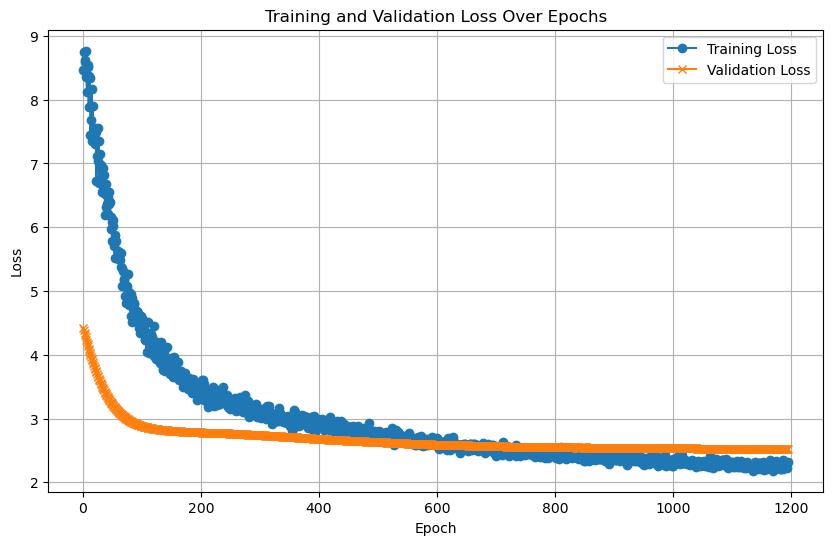

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 5.6681
Test Batch [20/167], Loss: 5.4876
Test Batch [30/167], Loss: 5.5155
Test Batch [40/167], Loss: 5.8409


Test Batch [50/167], Loss: 5.5475


Test Batch [60/167], Loss: 5.6409
Test Batch [70/167], Loss: 5.5502
Test Batch [80/167], Loss: 5.9050
Test Batch [90/167], Loss: 5.1481
Test Batch [100/167], Loss: 5.2798
Test Batch [110/167], Loss: 5.3804
Test Batch [120/167], Loss: 5.5402
Test Batch [130/167], Loss: 5.5320
Test Batch [140/167], Loss: 5.4642
Test Batch [150/167], Loss: 5.3818


Test Batch [160/167], Loss: 6.0385

Test Loss: 5.4699


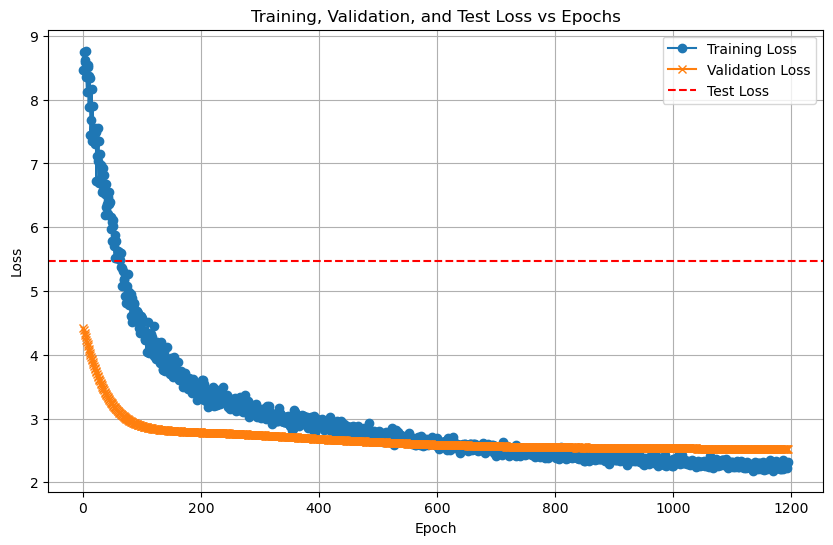

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.


  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.67      0.80      0.73         5
           2       0.67      0.40      0.50         5
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       0.80      0.80      0.80         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.79        45
weighted avg       0.80      0.80      0.79        45


LOG: Evaluating on the test set...
Test Accuracy: 67.49%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1349  |  Val Loss: 2.1103
Validation loss improved from inf to 2.1103.
[Epoch 2/1000] Train Loss: 2.1256  |  Val Loss: 2.1031
Validation loss improved from 2.1103 to 2.1031.
[Epoch 3/1000] Train Loss: 2.1170  |  Val Loss: 2.0959
Validation loss improved from 2.1031 to 2.0959.
[Epoch 4/1000] Train Loss: 2.1085  |  Val Loss: 2.0888
Validation loss improved from 2.0959 to 2.0888.
[Epoch 5/1000] Train Loss: 2.1001  |  Val Loss: 2.0816
Validation loss improved from 2.0888 to 2.0816.
[Epoch 6/1000] Train Loss: 2.0917  |  Val Loss: 2.0745
Validation loss improved from 2.0816 to 2.0745.
[Epoch 7/1000] Train Loss: 2.0834  |  Val Loss: 2.0675
Validation loss improved from 2.0745 to 2.0675.
[Epoch 8/1000] Train Loss: 2.0753  |  Val Loss: 2.0605
Validation loss improved from 2.0675 to 2.0605.
[Epoch 9/1000] Train Loss: 2.0671  |  Val Loss: 2.0534
Validation loss improved from 2.0605 to 2.0534.
[Epoch 10/1000] Train Loss: 2.0589  |  Val Loss: 2.0463
Validation loss impr

[Epoch 14/1000] Train Loss: 2.0272  |  Val Loss: 2.0180
Validation loss improved from 2.0249 to 2.0180.
[Epoch 15/1000] Train Loss: 2.0195  |  Val Loss: 2.0110
Validation loss improved from 2.0180 to 2.0110.
[Epoch 16/1000] Train Loss: 2.0118  |  Val Loss: 2.0041
Validation loss improved from 2.0110 to 2.0041.
[Epoch 17/1000] Train Loss: 2.0041  |  Val Loss: 1.9972
Validation loss improved from 2.0041 to 1.9972.
[Epoch 18/1000] Train Loss: 1.9964  |  Val Loss: 1.9903
Validation loss improved from 1.9972 to 1.9903.
[Epoch 19/1000] Train Loss: 1.9889  |  Val Loss: 1.9834
Validation loss improved from 1.9903 to 1.9834.
[Epoch 20/1000] Train Loss: 1.9814  |  Val Loss: 1.9764
Validation loss improved from 1.9834 to 1.9764.
[Epoch 21/1000] Train Loss: 1.9739  |  Val Loss: 1.9695
Validation loss improved from 1.9764 to 1.9695.
[Epoch 22/1000] Train Loss: 1.9665  |  Val Loss: 1.9626
Validation loss improved from 1.9695 to 1.9626.
[Epoch 23/1000] Train Loss: 1.9591  |  Val Loss: 1.9557
Validati

[Epoch 71/1000] Train Loss: 1.6666  |  Val Loss: 1.6992
Validation loss improved from 1.7038 to 1.6992.
[Epoch 72/1000] Train Loss: 1.6613  |  Val Loss: 1.6946
Validation loss improved from 1.6992 to 1.6946.
[Epoch 73/1000] Train Loss: 1.6561  |  Val Loss: 1.6900
Validation loss improved from 1.6946 to 1.6900.
[Epoch 74/1000] Train Loss: 1.6508  |  Val Loss: 1.6855
Validation loss improved from 1.6900 to 1.6855.
[Epoch 75/1000] Train Loss: 1.6456  |  Val Loss: 1.6811
Validation loss improved from 1.6855 to 1.6811.
[Epoch 76/1000] Train Loss: 1.6404  |  Val Loss: 1.6767
Validation loss improved from 1.6811 to 1.6767.
[Epoch 77/1000] Train Loss: 1.6353  |  Val Loss: 1.6724
Validation loss improved from 1.6767 to 1.6724.
[Epoch 78/1000] Train Loss: 1.6302  |  Val Loss: 1.6680
Validation loss improved from 1.6724 to 1.6680.
[Epoch 79/1000] Train Loss: 1.6252  |  Val Loss: 1.6637
Validation loss improved from 1.6680 to 1.6637.
[Epoch 80/1000] Train Loss: 1.6201  |  Val Loss: 1.6595
Validati

[Epoch 89/1000] Train Loss: 1.5748  |  Val Loss: 1.6212
Validation loss improved from 1.6255 to 1.6212.
[Epoch 90/1000] Train Loss: 1.5698  |  Val Loss: 1.6170
Validation loss improved from 1.6212 to 1.6170.
[Epoch 91/1000] Train Loss: 1.5648  |  Val Loss: 1.6129
Validation loss improved from 1.6170 to 1.6129.
[Epoch 92/1000] Train Loss: 1.5599  |  Val Loss: 1.6086
Validation loss improved from 1.6129 to 1.6086.
[Epoch 93/1000] Train Loss: 1.5549  |  Val Loss: 1.6044
Validation loss improved from 1.6086 to 1.6044.
[Epoch 94/1000] Train Loss: 1.5499  |  Val Loss: 1.6002
Validation loss improved from 1.6044 to 1.6002.
[Epoch 95/1000] Train Loss: 1.5449  |  Val Loss: 1.5959
Validation loss improved from 1.6002 to 1.5959.
[Epoch 96/1000] Train Loss: 1.5400  |  Val Loss: 1.5917
Validation loss improved from 1.5959 to 1.5917.
[Epoch 97/1000] Train Loss: 1.5351  |  Val Loss: 1.5874
Validation loss improved from 1.5917 to 1.5874.
[Epoch 98/1000] Train Loss: 1.5302  |  Val Loss: 1.5831
Validati

[Epoch 144/1000] Train Loss: 1.3104  |  Val Loss: 1.4019
Validation loss improved from 1.4056 to 1.4019.
[Epoch 145/1000] Train Loss: 1.3058  |  Val Loss: 1.3981
Validation loss improved from 1.4019 to 1.3981.
[Epoch 146/1000] Train Loss: 1.3012  |  Val Loss: 1.3944
Validation loss improved from 1.3981 to 1.3944.
[Epoch 147/1000] Train Loss: 1.2966  |  Val Loss: 1.3906
Validation loss improved from 1.3944 to 1.3906.
[Epoch 148/1000] Train Loss: 1.2920  |  Val Loss: 1.3869
Validation loss improved from 1.3906 to 1.3869.
[Epoch 149/1000] Train Loss: 1.2874  |  Val Loss: 1.3831
Validation loss improved from 1.3869 to 1.3831.
[Epoch 150/1000] Train Loss: 1.2828  |  Val Loss: 1.3794
Validation loss improved from 1.3831 to 1.3794.
[Epoch 151/1000] Train Loss: 1.2782  |  Val Loss: 1.3756
Validation loss improved from 1.3794 to 1.3756.
[Epoch 152/1000] Train Loss: 1.2737  |  Val Loss: 1.3719
Validation loss improved from 1.3756 to 1.3719.
[Epoch 153/1000] Train Loss: 1.2691  |  Val Loss: 1.368

[Epoch 158/1000] Train Loss: 1.2467  |  Val Loss: 1.3496
Validation loss improved from 1.3533 to 1.3496.
[Epoch 159/1000] Train Loss: 1.2422  |  Val Loss: 1.3459
Validation loss improved from 1.3496 to 1.3459.
[Epoch 160/1000] Train Loss: 1.2378  |  Val Loss: 1.3422
Validation loss improved from 1.3459 to 1.3422.
[Epoch 161/1000] Train Loss: 1.2333  |  Val Loss: 1.3385
Validation loss improved from 1.3422 to 1.3385.
[Epoch 162/1000] Train Loss: 1.2289  |  Val Loss: 1.3348
Validation loss improved from 1.3385 to 1.3348.
[Epoch 163/1000] Train Loss: 1.2245  |  Val Loss: 1.3311
Validation loss improved from 1.3348 to 1.3311.
[Epoch 164/1000] Train Loss: 1.2201  |  Val Loss: 1.3275
Validation loss improved from 1.3311 to 1.3275.
[Epoch 165/1000] Train Loss: 1.2157  |  Val Loss: 1.3238
Validation loss improved from 1.3275 to 1.3238.
[Epoch 166/1000] Train Loss: 1.2114  |  Val Loss: 1.3201
Validation loss improved from 1.3238 to 1.3201.
[Epoch 167/1000] Train Loss: 1.2070  |  Val Loss: 1.316

[Epoch 219/1000] Train Loss: 0.9795  |  Val Loss: 1.1291
Validation loss improved from 1.1326 to 1.1291.
[Epoch 220/1000] Train Loss: 0.9752  |  Val Loss: 1.1255
Validation loss improved from 1.1291 to 1.1255.
[Epoch 221/1000] Train Loss: 0.9709  |  Val Loss: 1.1221
Validation loss improved from 1.1255 to 1.1221.
[Epoch 222/1000] Train Loss: 0.9666  |  Val Loss: 1.1187
Validation loss improved from 1.1221 to 1.1187.
[Epoch 223/1000] Train Loss: 0.9623  |  Val Loss: 1.1153
Validation loss improved from 1.1187 to 1.1153.
[Epoch 224/1000] Train Loss: 0.9580  |  Val Loss: 1.1120
Validation loss improved from 1.1153 to 1.1120.
[Epoch 225/1000] Train Loss: 0.9537  |  Val Loss: 1.1087
Validation loss improved from 1.1120 to 1.1087.
[Epoch 226/1000] Train Loss: 0.9495  |  Val Loss: 1.1054
Validation loss improved from 1.1087 to 1.1054.
[Epoch 227/1000] Train Loss: 0.9452  |  Val Loss: 1.1021
Validation loss improved from 1.1054 to 1.1021.
[Epoch 228/1000] Train Loss: 0.9410  |  Val Loss: 1.098

[Epoch 236/1000] Train Loss: 0.9074  |  Val Loss: 1.0725
Validation loss improved from 1.0758 to 1.0725.
[Epoch 237/1000] Train Loss: 0.9033  |  Val Loss: 1.0692
Validation loss improved from 1.0725 to 1.0692.
[Epoch 238/1000] Train Loss: 0.8991  |  Val Loss: 1.0658
Validation loss improved from 1.0692 to 1.0658.
[Epoch 239/1000] Train Loss: 0.8949  |  Val Loss: 1.0625
Validation loss improved from 1.0658 to 1.0625.
[Epoch 240/1000] Train Loss: 0.8908  |  Val Loss: 1.0592
Validation loss improved from 1.0625 to 1.0592.
[Epoch 241/1000] Train Loss: 0.8866  |  Val Loss: 1.0559
Validation loss improved from 1.0592 to 1.0559.
[Epoch 242/1000] Train Loss: 0.8825  |  Val Loss: 1.0525
Validation loss improved from 1.0559 to 1.0525.
[Epoch 243/1000] Train Loss: 0.8784  |  Val Loss: 1.0493
Validation loss improved from 1.0525 to 1.0493.
[Epoch 244/1000] Train Loss: 0.8743  |  Val Loss: 1.0460
Validation loss improved from 1.0493 to 1.0460.
[Epoch 245/1000] Train Loss: 0.8702  |  Val Loss: 1.042

[Epoch 290/1000] Train Loss: 0.6981  |  Val Loss: 0.9074
Validation loss improved from 0.9102 to 0.9074.
[Epoch 291/1000] Train Loss: 0.6946  |  Val Loss: 0.9046
Validation loss improved from 0.9074 to 0.9046.
[Epoch 292/1000] Train Loss: 0.6911  |  Val Loss: 0.9018
Validation loss improved from 0.9046 to 0.9018.
[Epoch 293/1000] Train Loss: 0.6876  |  Val Loss: 0.8991
Validation loss improved from 0.9018 to 0.8991.
[Epoch 294/1000] Train Loss: 0.6841  |  Val Loss: 0.8964
Validation loss improved from 0.8991 to 0.8964.
[Epoch 295/1000] Train Loss: 0.6807  |  Val Loss: 0.8937
Validation loss improved from 0.8964 to 0.8937.
[Epoch 296/1000] Train Loss: 0.6772  |  Val Loss: 0.8909
Validation loss improved from 0.8937 to 0.8909.
[Epoch 297/1000] Train Loss: 0.6738  |  Val Loss: 0.8882
Validation loss improved from 0.8909 to 0.8882.
[Epoch 298/1000] Train Loss: 0.6703  |  Val Loss: 0.8855
Validation loss improved from 0.8882 to 0.8855.
[Epoch 299/1000] Train Loss: 0.6669  |  Val Loss: 0.882

[Epoch 313/1000] Train Loss: 0.6205  |  Val Loss: 0.8464
Validation loss improved from 0.8489 to 0.8464.
[Epoch 314/1000] Train Loss: 0.6173  |  Val Loss: 0.8438
Validation loss improved from 0.8464 to 0.8438.
[Epoch 315/1000] Train Loss: 0.6141  |  Val Loss: 0.8413
Validation loss improved from 0.8438 to 0.8413.
[Epoch 316/1000] Train Loss: 0.6109  |  Val Loss: 0.8388
Validation loss improved from 0.8413 to 0.8388.
[Epoch 317/1000] Train Loss: 0.6077  |  Val Loss: 0.8363
Validation loss improved from 0.8388 to 0.8363.
[Epoch 318/1000] Train Loss: 0.6045  |  Val Loss: 0.8338
Validation loss improved from 0.8363 to 0.8338.
[Epoch 319/1000] Train Loss: 0.6014  |  Val Loss: 0.8314
Validation loss improved from 0.8338 to 0.8314.
[Epoch 320/1000] Train Loss: 0.5982  |  Val Loss: 0.8289
Validation loss improved from 0.8314 to 0.8289.
[Epoch 321/1000] Train Loss: 0.5951  |  Val Loss: 0.8264
Validation loss improved from 0.8289 to 0.8264.
[Epoch 322/1000] Train Loss: 0.5919  |  Val Loss: 0.824

[Epoch 360/1000] Train Loss: 0.4848  |  Val Loss: 0.7392
Validation loss improved from 0.7413 to 0.7392.
[Epoch 361/1000] Train Loss: 0.4823  |  Val Loss: 0.7372
Validation loss improved from 0.7392 to 0.7372.
[Epoch 362/1000] Train Loss: 0.4799  |  Val Loss: 0.7352
Validation loss improved from 0.7372 to 0.7352.
[Epoch 363/1000] Train Loss: 0.4774  |  Val Loss: 0.7332
Validation loss improved from 0.7352 to 0.7332.
[Epoch 364/1000] Train Loss: 0.4749  |  Val Loss: 0.7312
Validation loss improved from 0.7332 to 0.7312.
[Epoch 365/1000] Train Loss: 0.4725  |  Val Loss: 0.7293
Validation loss improved from 0.7312 to 0.7293.
[Epoch 366/1000] Train Loss: 0.4701  |  Val Loss: 0.7273
Validation loss improved from 0.7293 to 0.7273.
[Epoch 367/1000] Train Loss: 0.4677  |  Val Loss: 0.7254
Validation loss improved from 0.7273 to 0.7254.
[Epoch 368/1000] Train Loss: 0.4653  |  Val Loss: 0.7235
Validation loss improved from 0.7254 to 0.7235.
[Epoch 369/1000] Train Loss: 0.4629  |  Val Loss: 0.721

[Epoch 395/1000] Train Loss: 0.4077  |  Val Loss: 0.6793
Validation loss improved from 0.6807 to 0.6793.
[Epoch 396/1000] Train Loss: 0.4058  |  Val Loss: 0.6779
Validation loss improved from 0.6793 to 0.6779.
[Epoch 397/1000] Train Loss: 0.4039  |  Val Loss: 0.6765
Validation loss improved from 0.6779 to 0.6765.
[Epoch 398/1000] Train Loss: 0.4020  |  Val Loss: 0.6752
Validation loss improved from 0.6765 to 0.6752.
[Epoch 399/1000] Train Loss: 0.4001  |  Val Loss: 0.6739
Validation loss improved from 0.6752 to 0.6739.
[Epoch 400/1000] Train Loss: 0.3983  |  Val Loss: 0.6726
Validation loss improved from 0.6739 to 0.6726.
[Epoch 401/1000] Train Loss: 0.3964  |  Val Loss: 0.6713
Validation loss improved from 0.6726 to 0.6713.
[Epoch 402/1000] Train Loss: 0.3946  |  Val Loss: 0.6700
Validation loss improved from 0.6713 to 0.6700.
[Epoch 403/1000] Train Loss: 0.3928  |  Val Loss: 0.6687
Validation loss improved from 0.6700 to 0.6687.
[Epoch 404/1000] Train Loss: 0.3911  |  Val Loss: 0.667

[Epoch 436/1000] Train Loss: 0.3409  |  Val Loss: 0.6310
Validation loss improved from 0.6320 to 0.6310.
[Epoch 437/1000] Train Loss: 0.3395  |  Val Loss: 0.6300
Validation loss improved from 0.6310 to 0.6300.
[Epoch 438/1000] Train Loss: 0.3381  |  Val Loss: 0.6291
Validation loss improved from 0.6300 to 0.6291.
[Epoch 439/1000] Train Loss: 0.3368  |  Val Loss: 0.6282
Validation loss improved from 0.6291 to 0.6282.
[Epoch 440/1000] Train Loss: 0.3355  |  Val Loss: 0.6273
Validation loss improved from 0.6282 to 0.6273.
[Epoch 441/1000] Train Loss: 0.3342  |  Val Loss: 0.6264
Validation loss improved from 0.6273 to 0.6264.
[Epoch 442/1000] Train Loss: 0.3328  |  Val Loss: 0.6255
Validation loss improved from 0.6264 to 0.6255.
[Epoch 443/1000] Train Loss: 0.3316  |  Val Loss: 0.6247
Validation loss improved from 0.6255 to 0.6247.
[Epoch 444/1000] Train Loss: 0.3303  |  Val Loss: 0.6238
Validation loss improved from 0.6247 to 0.6238.
[Epoch 445/1000] Train Loss: 0.3290  |  Val Loss: 0.622

[Epoch 468/1000] Train Loss: 0.3025  |  Val Loss: 0.6055
Validation loss improved from 0.6061 to 0.6055.
[Epoch 469/1000] Train Loss: 0.3015  |  Val Loss: 0.6049
Validation loss improved from 0.6055 to 0.6049.
[Epoch 470/1000] Train Loss: 0.3005  |  Val Loss: 0.6042
Validation loss improved from 0.6049 to 0.6042.
[Epoch 471/1000] Train Loss: 0.2994  |  Val Loss: 0.6036
Validation loss improved from 0.6042 to 0.6036.
[Epoch 472/1000] Train Loss: 0.2984  |  Val Loss: 0.6030
Validation loss improved from 0.6036 to 0.6030.
[Epoch 473/1000] Train Loss: 0.2974  |  Val Loss: 0.6024
Validation loss improved from 0.6030 to 0.6024.
[Epoch 474/1000] Train Loss: 0.2964  |  Val Loss: 0.6017
Validation loss improved from 0.6024 to 0.6017.
[Epoch 475/1000] Train Loss: 0.2954  |  Val Loss: 0.6011
Validation loss improved from 0.6017 to 0.6011.
[Epoch 476/1000] Train Loss: 0.2945  |  Val Loss: 0.6005
Validation loss improved from 0.6011 to 0.6005.
[Epoch 477/1000] Train Loss: 0.2935  |  Val Loss: 0.599

[Epoch 509/1000] Train Loss: 0.2664  |  Val Loss: 0.5832
Validation loss improved from 0.5837 to 0.5832.
[Epoch 510/1000] Train Loss: 0.2656  |  Val Loss: 0.5827
Validation loss improved from 0.5832 to 0.5827.
[Epoch 511/1000] Train Loss: 0.2649  |  Val Loss: 0.5822
Validation loss improved from 0.5827 to 0.5822.
[Epoch 512/1000] Train Loss: 0.2641  |  Val Loss: 0.5817
Validation loss improved from 0.5822 to 0.5817.
[Epoch 513/1000] Train Loss: 0.2634  |  Val Loss: 0.5813
Validation loss improved from 0.5817 to 0.5813.
[Epoch 514/1000] Train Loss: 0.2627  |  Val Loss: 0.5809
Validation loss improved from 0.5813 to 0.5809.
[Epoch 515/1000] Train Loss: 0.2620  |  Val Loss: 0.5805
Validation loss improved from 0.5809 to 0.5805.
[Epoch 516/1000] Train Loss: 0.2613  |  Val Loss: 0.5801
Validation loss improved from 0.5805 to 0.5801.
[Epoch 517/1000] Train Loss: 0.2606  |  Val Loss: 0.5796
Validation loss improved from 0.5801 to 0.5796.
[Epoch 518/1000] Train Loss: 0.2599  |  Val Loss: 0.579

[Epoch 541/1000] Train Loss: 0.2452  |  Val Loss: 0.5708
Validation loss improved from 0.5712 to 0.5708.
[Epoch 542/1000] Train Loss: 0.2446  |  Val Loss: 0.5705
Validation loss improved from 0.5708 to 0.5705.
[Epoch 543/1000] Train Loss: 0.2440  |  Val Loss: 0.5702
Validation loss improved from 0.5705 to 0.5702.
[Epoch 544/1000] Train Loss: 0.2435  |  Val Loss: 0.5700
Validation loss improved from 0.5702 to 0.5700.
[Epoch 545/1000] Train Loss: 0.2429  |  Val Loss: 0.5697
Validation loss improved from 0.5700 to 0.5697.
[Epoch 546/1000] Train Loss: 0.2423  |  Val Loss: 0.5694
Validation loss improved from 0.5697 to 0.5694.
[Epoch 547/1000] Train Loss: 0.2417  |  Val Loss: 0.5691
Validation loss improved from 0.5694 to 0.5691.
[Epoch 548/1000] Train Loss: 0.2412  |  Val Loss: 0.5689
Validation loss improved from 0.5691 to 0.5689.
[Epoch 549/1000] Train Loss: 0.2406  |  Val Loss: 0.5686
Validation loss improved from 0.5689 to 0.5686.
[Epoch 550/1000] Train Loss: 0.2401  |  Val Loss: 0.568

[Epoch 579/1000] Train Loss: 0.2254  |  Val Loss: 0.5623
Validation loss improved from 0.5624 to 0.5623.
[Epoch 580/1000] Train Loss: 0.2249  |  Val Loss: 0.5621
Validation loss improved from 0.5623 to 0.5621.
[Epoch 581/1000] Train Loss: 0.2245  |  Val Loss: 0.5619
Validation loss improved from 0.5621 to 0.5619.
[Epoch 582/1000] Train Loss: 0.2240  |  Val Loss: 0.5618
Validation loss improved from 0.5619 to 0.5618.
[Epoch 583/1000] Train Loss: 0.2236  |  Val Loss: 0.5616
Validation loss improved from 0.5618 to 0.5616.
[Epoch 584/1000] Train Loss: 0.2231  |  Val Loss: 0.5615
Validation loss improved from 0.5616 to 0.5615.
[Epoch 585/1000] Train Loss: 0.2227  |  Val Loss: 0.5614
Validation loss improved from 0.5615 to 0.5614.
[Epoch 586/1000] Train Loss: 0.2222  |  Val Loss: 0.5613
Validation loss improved from 0.5614 to 0.5613.
[Epoch 587/1000] Train Loss: 0.2218  |  Val Loss: 0.5612
Validation loss improved from 0.5613 to 0.5612.
[Epoch 588/1000] Train Loss: 0.2213  |  Val Loss: 0.561

[Epoch 618/1000] Train Loss: 0.2090  |  Val Loss: 0.5575
Validation loss improved from 0.5576 to 0.5575.
[Epoch 619/1000] Train Loss: 0.2086  |  Val Loss: 0.5575
Validation loss improved from 0.5575 to 0.5575.
[Epoch 620/1000] Train Loss: 0.2083  |  Val Loss: 0.5574
Validation loss improved from 0.5575 to 0.5574.
[Epoch 621/1000] Train Loss: 0.2079  |  Val Loss: 0.5573
Validation loss improved from 0.5574 to 0.5573.
[Epoch 622/1000] Train Loss: 0.2075  |  Val Loss: 0.5572
Validation loss improved from 0.5573 to 0.5572.
[Epoch 623/1000] Train Loss: 0.2071  |  Val Loss: 0.5571
Validation loss improved from 0.5572 to 0.5571.
[Epoch 624/1000] Train Loss: 0.2068  |  Val Loss: 0.5570
Validation loss improved from 0.5571 to 0.5570.
[Epoch 625/1000] Train Loss: 0.2064  |  Val Loss: 0.5568
Validation loss improved from 0.5570 to 0.5568.
[Epoch 626/1000] Train Loss: 0.2060  |  Val Loss: 0.5567
Validation loss improved from 0.5568 to 0.5567.
[Epoch 627/1000] Train Loss: 0.2056  |  Val Loss: 0.556

[Epoch 656/1000] Train Loss: 0.1955  |  Val Loss: 0.5547
Validation loss improved from 0.5547 to 0.5547.
[Epoch 657/1000] Train Loss: 0.1952  |  Val Loss: 0.5546
Validation loss improved from 0.5547 to 0.5546.
[Epoch 658/1000] Train Loss: 0.1949  |  Val Loss: 0.5545
Validation loss improved from 0.5546 to 0.5545.
[Epoch 659/1000] Train Loss: 0.1946  |  Val Loss: 0.5544
Validation loss improved from 0.5545 to 0.5544.
[Epoch 660/1000] Train Loss: 0.1942  |  Val Loss: 0.5543
Validation loss improved from 0.5544 to 0.5543.
[Epoch 661/1000] Train Loss: 0.1939  |  Val Loss: 0.5543
Validation loss improved from 0.5543 to 0.5543.
[Epoch 662/1000] Train Loss: 0.1936  |  Val Loss: 0.5543
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 663/1000] Train Loss: 0.1932  |  Val Loss: 0.5543
Validation loss improved from 0.5543 to 0.5543.
[Epoch 664/1000] Train Loss: 0.1929  |  Val Loss: 0.5542
Validation loss improved from 0.5543 to 0.5542.
[Epoch 665/1000] Train Loss: 0.1926  |  Val Loss:

[Epoch 693/1000] Train Loss: 0.1839  |  Val Loss: 0.5533
Validation loss improved from 0.5533 to 0.5533.
[Epoch 694/1000] Train Loss: 0.1836  |  Val Loss: 0.5533
Validation loss improved from 0.5533 to 0.5533.
[Epoch 695/1000] Train Loss: 0.1833  |  Val Loss: 0.5533
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 696/1000] Train Loss: 0.1830  |  Val Loss: 0.5533
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 697/1000] Train Loss: 0.1827  |  Val Loss: 0.5532
Validation loss improved from 0.5533 to 0.5532.
[Epoch 698/1000] Train Loss: 0.1824  |  Val Loss: 0.5532
Validation loss improved from 0.5532 to 0.5532.
[Epoch 699/1000] Train Loss: 0.1821  |  Val Loss: 0.5532
Validation loss improved from 0.5532 to 0.5532.
[Epoch 700/1000] Train Loss: 0.1819  |  Val Loss: 0.5531
Validation loss improved from 0.5532 to 0.5531.
[Epoch 701/1000] Train Loss: 0.1816  |  Val Loss: 0.5531
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 702/1000] Train Loss: 0.1813  

[Epoch 731/1000] Train Loss: 0.1729  |  Val Loss: 0.5528
Validation loss improved from 0.5528 to 0.5528.
[Epoch 732/1000] Train Loss: 0.1727  |  Val Loss: 0.5527
Validation loss improved from 0.5528 to 0.5527.
[Epoch 733/1000] Train Loss: 0.1724  |  Val Loss: 0.5526
Validation loss improved from 0.5527 to 0.5526.
[Epoch 734/1000] Train Loss: 0.1721  |  Val Loss: 0.5526
Validation loss improved from 0.5526 to 0.5526.
[Epoch 735/1000] Train Loss: 0.1718  |  Val Loss: 0.5526
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 736/1000] Train Loss: 0.1715  |  Val Loss: 0.5526
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 737/1000] Train Loss: 0.1712  |  Val Loss: 0.5527
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 738/1000] Train Loss: 0.1710  |  Val Loss: 0.5527
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 739/1000] Train Loss: 0.1707  |  Val Loss: 0.5526
Validation loss improved from 0.5526 to 0.5526.
[Epoch 740/1000] Train Loss: 0.

[Epoch 775/1000] Train Loss: 0.1609  |  Val Loss: 0.5517
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 776/1000] Train Loss: 0.1606  |  Val Loss: 0.5517
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 777/1000] Train Loss: 0.1603  |  Val Loss: 0.5518
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 778/1000] Train Loss: 0.1601  |  Val Loss: 0.5518
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 779/1000] Train Loss: 0.1598  |  Val Loss: 0.5517
Validation loss improved from 0.5517 to 0.5517.
[Epoch 780/1000] Train Loss: 0.1595  |  Val Loss: 0.5516
Validation loss improved from 0.5517 to 0.5516.
[Epoch 781/1000] Train Loss: 0.1593  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 782/1000] Train Loss: 0.1590  |  Val Loss: 0.5517
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 783/1000] Train Loss: 0.1588  |  Val Loss: 0.5518
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 784/1

[Epoch 807/1000] Train Loss: 0.1519  |  Val Loss: 0.5512
Validation loss improved from 0.5513 to 0.5512.
[Epoch 808/1000] Train Loss: 0.1514  |  Val Loss: 0.5511
Validation loss improved from 0.5512 to 0.5511.
[Epoch 809/1000] Train Loss: 0.1511  |  Val Loss: 0.5509
Validation loss improved from 0.5511 to 0.5509.
[Epoch 810/1000] Train Loss: 0.1507  |  Val Loss: 0.5509
Validation loss improved from 0.5509 to 0.5509.
[Epoch 811/1000] Train Loss: 0.1504  |  Val Loss: 0.5508
Validation loss improved from 0.5509 to 0.5508.
[Epoch 812/1000] Train Loss: 0.1501  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 813/1000] Train Loss: 0.1498  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 814/1000] Train Loss: 0.1495  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 815/1000] Train Loss: 0.1493  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 816/1000] Train Loss: 0.

[Epoch 844/1000] Train Loss: 0.1414  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 845/1000] Train Loss: 0.1411  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 846/1000] Train Loss: 0.1409  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 847/1000] Train Loss: 0.1406  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 848/1000] Train Loss: 0.1403  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 849/1000] Train Loss: 0.1401  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 850/1000] Train Loss: 0.1398  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 851/1000] Train Loss: 0.1395  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 852/1000] Train Loss: 0.1393  |  Val Loss: 0.5510
!! Validation loss did NOT improve !! Patience:

[Epoch 879/1000] Train Loss: 0.1320  |  Val Loss: 0.5507
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 880/1000] Train Loss: 0.1318  |  Val Loss: 0.5507
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 881/1000] Train Loss: 0.1315  |  Val Loss: 0.5506
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 882/1000] Train Loss: 0.1312  |  Val Loss: 0.5507
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 883/1000] Train Loss: 0.1310  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 884/1000] Train Loss: 0.1307  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 885/1000] Train Loss: 0.1305  |  Val Loss: 0.5507
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 886/1000] Train Loss: 0.1302  |  Val Loss: 0.5507
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 887/1000] Train Loss: 0.1299  |  Val Loss: 0.5508
!! Validation loss did NOT improve !! Patience:

[Epoch 923/1000] Train Loss: 0.1206  |  Val Loss: 0.5513
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 924/1000] Train Loss: 0.1203  |  Val Loss: 0.5513
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 925/1000] Train Loss: 0.1201  |  Val Loss: 0.5513
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 926/1000] Train Loss: 0.1198  |  Val Loss: 0.5514
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 927/1000] Train Loss: 0.1196  |  Val Loss: 0.5515
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 928/1000] Train Loss: 0.1193  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 929/1000] Train Loss: 0.1190  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 930/1000] Train Loss: 0.1188  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 931/1000] Train Loss: 0.1185  |  Val Loss: 0.5515
!! Validation loss did NOT improve !! Patience:

[Epoch 957/1000] Train Loss: 0.1120  |  Val Loss: 0.5524
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 958/1000] Train Loss: 0.1117  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 959/1000] Train Loss: 0.1115  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 960/1000] Train Loss: 0.1112  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 961/1000] Train Loss: 0.1110  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 962/1000] Train Loss: 0.1107  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 963/1000] Train Loss: 0.1105  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 964/1000] Train Loss: 0.1102  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 965/1000] Train Loss: 0.1100  |  Val Loss: 0.5525
!! Validation loss did NOT improve !! Patience:

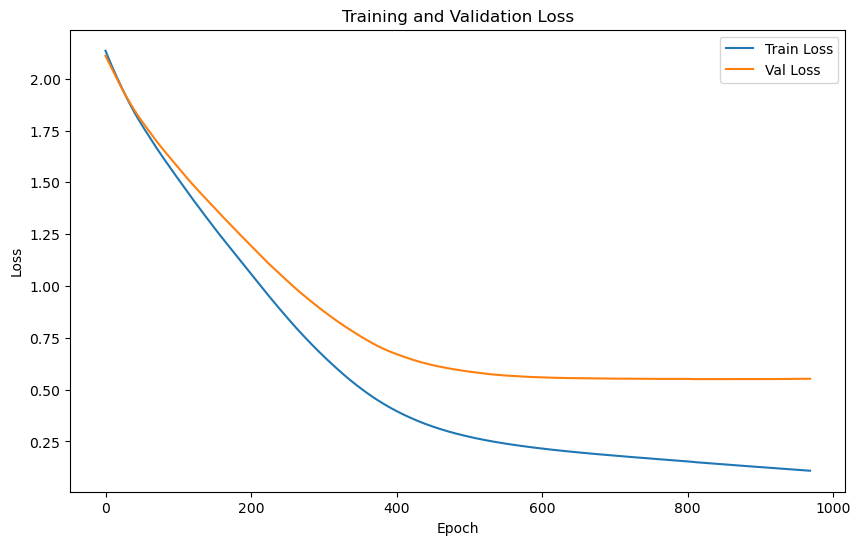

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.1076 | Test Accuracy: 66.06%


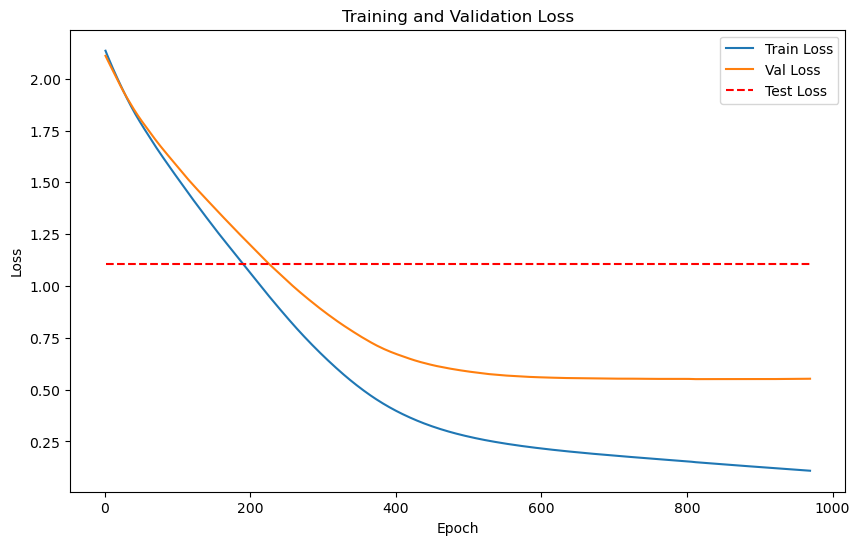

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4558
Epoch [1/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4558

Validation loss improved from inf to 0.4558. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4537
Epoch [2/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4537

Validation loss improved from 0.4558 to 0.4537. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4510
Epoch [3/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4510

Validation loss improved from 0.4537 to 0.4510. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4487
Epoch [4/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4487

Validation loss improved from 0.4510 to 0.4487. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4469
Epoch [5/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4469

Validation loss improved from 0.4487 to 0.4469. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4453
Epoch [6/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4453

Validation loss improved from 0.4469 to 0.4453. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4441
Epoch [7/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4441

Validation loss improved from 0.4453 to 0.4441. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4431
Epoch [8/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4431

Validation loss improved from 0.4441 to 0.4431. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4423
Epoch [9/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4423

Validation loss improved from 0.4431 to 0.4423. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.4416
Epoch [10/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4416

Validation loss improved from 0.4423 to 0.4416. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4408
Epoch [11/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4408

Validation loss improved from 0.4416 to 0.4408. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.4401
Epoch [12/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.4401

Validation loss improved from 0.4408 to 0.4401. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4391
Epoch [13/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4391

Validation loss improved from 0.4401 to 0.4391. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4379
Epoch [14/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4379

Validation loss improved from 0.4391 to 0.4379. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4370
Epoch [15/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4370

Validation loss improved from 0.4379 to 0.4370. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4362
Epoch [16/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.4362

Validation loss improved from 0.4370 to 0.4362. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4353
Epoch [17/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4353

Validation loss improved from 0.4362 to 0.4353. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4344
Epoch [18/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4344

Validation loss improved from 0.4353 to 0.4344. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.4336
Epoch [19/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.4336

Validation loss improved from 0.4344 to 0.4336. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4331
Epoch [20/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4331

Validation loss improved from 0.4336 to 0.4331. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4325
Epoch [21/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4325

Validation loss improved from 0.4331 to 0.4325. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4321
Epoch [22/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.4321

Validation loss improved from 0.4325 to 0.4321. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4316
Epoch [23/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.4316

Validation loss improved from 0.4321 to 0.4316. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4312
Epoch [24/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4312

Validation loss improved from 0.4316 to 0.4312. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4307
Epoch [25/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4307

Validation loss improved from 0.4312 to 0.4307. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [26/2000] - Validation


    Batch [1/1], Val Loss: 0.4303
Epoch [26/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.4303

Validation loss improved from 0.4307 to 0.4303. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4300
Epoch [27/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.4300

Validation loss improved from 0.4303 to 0.4300. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4296
Epoch [28/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.4296

Validation loss improved from 0.4300 to 0.4296. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4292
Epoch [29/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4292

Validation loss improved from 0.4296 to 0.4292. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4288
Epoch [30/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4288

Validation loss improved from 0.4292 to 0.4288. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4283
Epoch [31/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.4283

Validation loss improved from 0.4288 to 0.4283. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4278
Epoch [32/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.4278

Validation loss improved from 0.4283 to 0.4278. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4273
Epoch [33/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.4273

Validation loss improved from 0.4278 to 0.4273. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4267
Epoch [34/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.4267

Validation loss improved from 0.4273 to 0.4267. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.4262
Epoch [35/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.4262

Validation loss improved from 0.4267 to 0.4262. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4256
Epoch [36/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.4256

Validation loss improved from 0.4262 to 0.4256. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4250
Epoch [37/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.4250

Validation loss improved from 0.4256 to 0.4250. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4244
Epoch [38/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4244

Validation loss improved from 0.4250 to 0.4244. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4238
Epoch [39/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.4238

Validation loss improved from 0.4244 to 0.4238. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4232
Epoch [40/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4232

Validation loss improved from 0.4238 to 0.4232. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4226
Epoch [41/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.4226

Validation loss improved from 0.4232 to 0.4226. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.4220
Epoch [42/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.4220

Validation loss improved from 0.4226 to 0.4220. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4214
Epoch [43/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.4214

Validation loss improved from 0.4220 to 0.4214. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4208
Epoch [44/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.4208

Validation loss improved from 0.4214 to 0.4208. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4202
Epoch [45/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.4202

Validation loss improved from 0.4208 to 0.4202. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4196
Epoch [46/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.4196

Validation loss improved from 0.4202 to 0.4196. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4190
Epoch [47/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.4190

Validation loss improved from 0.4196 to 0.4190. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4183
Epoch [48/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.4183

Validation loss improved from 0.4190 to 0.4183. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.4177
Epoch [49/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.4177

Validation loss improved from 0.4183 to 0.4177. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4171
Epoch [50/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.4171

Validation loss improved from 0.4177 to 0.4171. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4165
Epoch [51/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.4165

Validation loss improved from 0.4171 to 0.4165. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4159
Epoch [52/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.4159

Validation loss improved from 0.4165 to 0.4159. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4154
Epoch [53/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.4154

Validation loss improved from 0.4159 to 0.4154. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4148
Epoch [54/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.4148

Validation loss improved from 0.4154 to 0.4148. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4143
Epoch [55/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.4143

Validation loss improved from 0.4148 to 0.4143. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.4138
Epoch [56/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.4138

Validation loss improved from 0.4143 to 0.4138. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4132
Epoch [57/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.4132

Validation loss improved from 0.4138 to 0.4132. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [58/2000] - Validation


    Batch [1/1], Val Loss: 0.4127
Epoch [58/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.4127

Validation loss improved from 0.4132 to 0.4127. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.4122
Epoch [59/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.4122

Validation loss improved from 0.4127 to 0.4122. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.4117
Epoch [60/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.4117

Validation loss improved from 0.4122 to 0.4117. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.4112
Epoch [61/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.4112

Validation loss improved from 0.4117 to 0.4112. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [62/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.4107

Validation loss improved from 0.4112 to 0.4107. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4102
Epoch [63/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.4102

Validation loss improved from 0.4107 to 0.4102. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [64/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.4097

Validation loss improved from 0.4102 to 0.4097. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.4093
Epoch [65/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.4093

Validation loss improved from 0.4097 to 0.4093. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.4088
Epoch [66/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.4088

Validation loss improved from 0.4093 to 0.4088. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.4083
Epoch [67/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.4083

Validation loss improved from 0.4088 to 0.4083. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.4079
Epoch [68/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.4079

Validation loss improved from 0.4083 to 0.4079. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.4074
Epoch [69/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.4074

Validation loss improved from 0.4079 to 0.4074. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.4070
Epoch [70/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.4070

Validation loss improved from 0.4074 to 0.4070. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [71/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.4065

Validation loss improved from 0.4070 to 0.4065. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4061
Epoch [72/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.4061

Validation loss improved from 0.4065 to 0.4061. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.4057
Epoch [73/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.4057

Validation loss improved from 0.4061 to 0.4057. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4054
Epoch [74/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.4054

Validation loss improved from 0.4057 to 0.4054. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [75/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.4050

Validation loss improved from 0.4054 to 0.4050. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.4046
Epoch [76/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.4046

Validation loss improved from 0.4050 to 0.4046. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4041
Epoch [77/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.4041

Validation loss improved from 0.4046 to 0.4041. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [78/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.4037

Validation loss improved from 0.4041 to 0.4037. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [79/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.4033

Validation loss improved from 0.4037 to 0.4033. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [80/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.4029

Validation loss improved from 0.4033 to 0.4029. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.4025
Epoch [81/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.4025

Validation loss improved from 0.4029 to 0.4025. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.4021
Epoch [82/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.4021

Validation loss improved from 0.4025 to 0.4021. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.4018
Epoch [83/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.4018

Validation loss improved from 0.4021 to 0.4018. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.4014
Epoch [84/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.4014

Validation loss improved from 0.4018 to 0.4014. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.4010
Epoch [85/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.4010

Validation loss improved from 0.4014 to 0.4010. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [86/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.4006

Validation loss improved from 0.4010 to 0.4006. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [87/2000] - Validation


    Batch [1/1], Val Loss: 0.4003
Epoch [87/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.4003

Validation loss improved from 0.4006 to 0.4003. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3999
Epoch [88/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3999

Validation loss improved from 0.4003 to 0.3999. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.3995
Epoch [89/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3995

Validation loss improved from 0.3999 to 0.3995. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3992
Epoch [90/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3992

Validation loss improved from 0.3995 to 0.3992. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3989
Epoch [91/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3989

Validation loss improved from 0.3992 to 0.3989. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3985
Epoch [92/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3985

Validation loss improved from 0.3989 to 0.3985. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3982
Epoch [93/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3982

Validation loss improved from 0.3985 to 0.3982. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.3978
Epoch [94/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3978

Validation loss improved from 0.3982 to 0.3978. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [95/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3975

Validation loss improved from 0.3978 to 0.3975. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3971
Epoch [96/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3971

Validation loss improved from 0.3975 to 0.3971. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [97/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3968

Validation loss improved from 0.3971 to 0.3968. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3965
Epoch [98/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.3965

Validation loss improved from 0.3968 to 0.3965. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3962
Epoch [99/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3962

Validation loss improved from 0.3965 to 0.3962. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [100/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3959

Validation loss improved from 0.3962 to 0.3959. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3956
Epoch [101/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3956

Validation loss improved from 0.3959 to 0.3956. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3953
Epoch [102/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3953

Validation loss improved from 0.3956 to 0.3953. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [103/2000] - Validation


    Batch [1/1], Val Loss: 0.3950
Epoch [103/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3950

Validation loss improved from 0.3953 to 0.3950. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3946
Epoch [104/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3946

Validation loss improved from 0.3950 to 0.3946. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3943
Epoch [105/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3943

Validation loss improved from 0.3946 to 0.3943. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [106/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3940

Validation loss improved from 0.3943 to 0.3940. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3937
Epoch [107/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3937

Validation loss improved from 0.3940 to 0.3937. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [108/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3934

Validation loss improved from 0.3937 to 0.3934. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.3931
Epoch [109/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3931

Validation loss improved from 0.3934 to 0.3931. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [110/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3928

Validation loss improved from 0.3931 to 0.3928. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.3924
Epoch [111/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3924

Validation loss improved from 0.3928 to 0.3924. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [112/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3921

Validation loss improved from 0.3924 to 0.3921. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [113/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3918

Validation loss improved from 0.3921 to 0.3918. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [114/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3915

Validation loss improved from 0.3918 to 0.3915. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3912
Epoch [115/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3912

Validation loss improved from 0.3915 to 0.3912. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.3909
Epoch [116/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.3909

Validation loss improved from 0.3912 to 0.3909. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3906
Epoch [117/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3906

Validation loss improved from 0.3909 to 0.3906. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [118/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3904

Validation loss improved from 0.3906 to 0.3904. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3901
Epoch [119/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3901

Validation loss improved from 0.3904 to 0.3901. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [120/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.3899

Validation loss improved from 0.3901 to 0.3899. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.3896
Epoch [121/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3896

Validation loss improved from 0.3899 to 0.3896. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [122/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3894

Validation loss improved from 0.3896 to 0.3894. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3891
Epoch [123/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3891

Validation loss improved from 0.3894 to 0.3891. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [124/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.3889

Validation loss improved from 0.3891 to 0.3889. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3886
Epoch [125/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3886

Validation loss improved from 0.3889 to 0.3886. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [126/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3883

Validation loss improved from 0.3886 to 0.3883. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3881
Epoch [127/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3881

Validation loss improved from 0.3883 to 0.3881. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.3878
Epoch [128/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3878

Validation loss improved from 0.3881 to 0.3878. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3876
Epoch [129/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3876

Validation loss improved from 0.3878 to 0.3876. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.3874
Epoch [130/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3874

Validation loss improved from 0.3876 to 0.3874. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [131/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3870
Epoch [132/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3870

Validation loss improved from 0.3873 to 0.3870. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [133/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3868

Validation loss improved from 0.3870 to 0.3868. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3866
Epoch [134/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3866

Validation loss improved from 0.3868 to 0.3866. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3863
Epoch [135/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3863

Validation loss improved from 0.3866 to 0.3863. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [136/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3860

Validation loss improved from 0.3863 to 0.3860. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [137/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [137/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3857

Validation loss improved from 0.3860 to 0.3857. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3354
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [138/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.3854

Validation loss improved from 0.3857 to 0.3854. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [139/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3851

Validation loss improved from 0.3854 to 0.3851. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [140/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.3847

Validation loss improved from 0.3851 to 0.3847. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [141/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3844

Validation loss improved from 0.3847 to 0.3844. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3841
Epoch [142/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3841

Validation loss improved from 0.3844 to 0.3841. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3838
Epoch [143/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.3838

Validation loss improved from 0.3841 to 0.3838. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [144/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3836

Validation loss improved from 0.3838 to 0.3836. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3833
Epoch [145/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.3833

Validation loss improved from 0.3836 to 0.3833. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [146/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3831

Validation loss improved from 0.3833 to 0.3831. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [147/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.3828

Validation loss improved from 0.3831 to 0.3828. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3826
Epoch [148/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.3826

Validation loss improved from 0.3828 to 0.3826. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [149/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.3824

Validation loss improved from 0.3826 to 0.3824. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [150/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.3822

Validation loss improved from 0.3824 to 0.3822. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3819
Epoch [151/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.3819

Validation loss improved from 0.3822 to 0.3819. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [152/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3817

Validation loss improved from 0.3819 to 0.3817. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [153/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.3815

Validation loss improved from 0.3817 to 0.3815. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [154/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3813

Validation loss improved from 0.3815 to 0.3813. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.3811
Epoch [155/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3811

Validation loss improved from 0.3813 to 0.3811. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [156/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3808

Validation loss improved from 0.3811 to 0.3808. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3806
Epoch [157/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3806

Validation loss improved from 0.3808 to 0.3806. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [158/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [159/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3803

Validation loss improved from 0.3805 to 0.3803. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [160/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3801

Validation loss improved from 0.3803 to 0.3801. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [161/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3799

Validation loss improved from 0.3801 to 0.3799. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [162/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3797

Validation loss improved from 0.3799 to 0.3797. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [163/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3796

Validation loss improved from 0.3797 to 0.3796. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3794
Epoch [164/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3794

Validation loss improved from 0.3796 to 0.3794. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3792
Epoch [165/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3792

Validation loss improved from 0.3794 to 0.3792. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.3790
Epoch [166/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3790

Validation loss improved from 0.3792 to 0.3790. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [167/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.3789

Validation loss improved from 0.3790 to 0.3789. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [168/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.3787

Validation loss improved from 0.3789 to 0.3787. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [169/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.3785

Validation loss improved from 0.3787 to 0.3785. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [170/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3783

Validation loss improved from 0.3785 to 0.3783. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [171/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.3781

Validation loss improved from 0.3783 to 0.3781. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [172/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3779

Validation loss improved from 0.3781 to 0.3779. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [173/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3778

Validation loss improved from 0.3779 to 0.3778. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3776
Epoch [174/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.3776

Validation loss improved from 0.3778 to 0.3776. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [175/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [176/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [177/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.3773

Validation loss improved from 0.3774 to 0.3773. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [178/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3771

Validation loss improved from 0.3773 to 0.3771. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [179/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3770

Validation loss improved from 0.3771 to 0.3770. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [180/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3769

Validation loss improved from 0.3770 to 0.3769. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [181/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3768

Validation loss improved from 0.3769 to 0.3768. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [182/2000] - Validation


    Batch [1/1], Val Loss: 0.3767
Epoch [182/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3767

Validation loss improved from 0.3768 to 0.3767. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [183/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.3766

Validation loss improved from 0.3767 to 0.3766. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [184/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3765

Validation loss improved from 0.3766 to 0.3765. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3764
Epoch [185/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.3764

Validation loss improved from 0.3765 to 0.3764. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [186/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3763

Validation loss improved from 0.3764 to 0.3763. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [187/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3762

Validation loss improved from 0.3763 to 0.3762. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [188/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [189/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.3761

Validation loss improved from 0.3761 to 0.3761. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [190/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3760

Validation loss improved from 0.3761 to 0.3760. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [191/2000] - Validation


    Batch [1/1], Val Loss: 0.3759
Epoch [191/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3759

Validation loss improved from 0.3760 to 0.3759. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2875
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [192/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.3757

Validation loss improved from 0.3759 to 0.3757. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [193/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3754
Epoch [194/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3754

Validation loss improved from 0.3756 to 0.3754. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [195/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3751

Validation loss improved from 0.3754 to 0.3751. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.3749
Epoch [196/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.3749

Validation loss improved from 0.3751 to 0.3749. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [197/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3747

Validation loss improved from 0.3749 to 0.3747. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [198/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3746

Validation loss improved from 0.3747 to 0.3746. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [199/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3744

Validation loss improved from 0.3746 to 0.3744. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [200/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.3742

Validation loss improved from 0.3744 to 0.3742. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.3740
Epoch [201/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3740

Validation loss improved from 0.3742 to 0.3740. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [202/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3738

Validation loss improved from 0.3740 to 0.3738. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [203/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [203/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3736

Validation loss improved from 0.3738 to 0.3736. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [204/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3733

Validation loss improved from 0.3736 to 0.3733. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [205/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3731

Validation loss improved from 0.3733 to 0.3731. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3729
Epoch [206/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3729

Validation loss improved from 0.3731 to 0.3729. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3728
Epoch [207/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.3728

Validation loss improved from 0.3729 to 0.3728. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3726
Epoch [208/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.3726

Validation loss improved from 0.3728 to 0.3726. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [209/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.3724

Validation loss improved from 0.3726 to 0.3724. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [210/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3722

Validation loss improved from 0.3724 to 0.3722. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3720
Epoch [211/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3720

Validation loss improved from 0.3722 to 0.3720. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.3718
Epoch [212/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3718

Validation loss improved from 0.3720 to 0.3718. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [213/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3717

Validation loss improved from 0.3718 to 0.3717. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.3716
Epoch [214/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3716

Validation loss improved from 0.3717 to 0.3716. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3714
Epoch [215/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3714

Validation loss improved from 0.3716 to 0.3714. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [216/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3713

Validation loss improved from 0.3714 to 0.3713. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [217/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3712

Validation loss improved from 0.3713 to 0.3712. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [218/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3711

Validation loss improved from 0.3712 to 0.3711. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.3710
Epoch [219/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [220/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [221/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [222/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3706
Epoch [223/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.3706

Validation loss improved from 0.3707 to 0.3706. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [224/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3706

Validation loss improved from 0.3706 to 0.3706. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [225/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3706

Validation loss improved from 0.3706 to 0.3706. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [226/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.3705

Validation loss improved from 0.3706 to 0.3705. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [227/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.3705

Validation loss improved from 0.3705 to 0.3705. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [228/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3704

Validation loss improved from 0.3705 to 0.3704. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [229/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.3704

Validation loss improved from 0.3704 to 0.3704. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [230/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3703

Validation loss improved from 0.3704 to 0.3703. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [231/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3702

Validation loss improved from 0.3703 to 0.3702. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.3702
Epoch [232/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3702

Validation loss improved from 0.3702 to 0.3702. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [233/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.3701

Validation loss improved from 0.3702 to 0.3701. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [234/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3700

Validation loss improved from 0.3701 to 0.3700. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [235/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3700

Validation loss improved from 0.3700 to 0.3700. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.3699
Epoch [236/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.3699

Validation loss improved from 0.3700 to 0.3699. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [237/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3697

Validation loss improved from 0.3699 to 0.3697. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3696
Epoch [238/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3696

Validation loss improved from 0.3697 to 0.3696. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [239/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.3695

Validation loss improved from 0.3696 to 0.3695. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.3694
Epoch [240/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3694

Validation loss improved from 0.3695 to 0.3694. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [241/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3693

Validation loss improved from 0.3694 to 0.3693. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [242/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3691

Validation loss improved from 0.3693 to 0.3691. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [243/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3690

Validation loss improved from 0.3691 to 0.3690. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [244/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.3688

Validation loss improved from 0.3690 to 0.3688. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3687
Epoch [245/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3687

Validation loss improved from 0.3688 to 0.3687. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [246/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.3686

Validation loss improved from 0.3687 to 0.3686. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.3685
Epoch [247/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3685

Validation loss improved from 0.3686 to 0.3685. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3684
Epoch [248/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.3684

Validation loss improved from 0.3685 to 0.3684. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [249/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3683

Validation loss improved from 0.3684 to 0.3683. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [250/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3683

Validation loss improved from 0.3683 to 0.3683. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [251/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3682

Validation loss improved from 0.3683 to 0.3682. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [252/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3682

Validation loss improved from 0.3682 to 0.3682. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [253/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.3681

Validation loss improved from 0.3682 to 0.3681. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.3680
Epoch [254/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.3680

Validation loss improved from 0.3681 to 0.3680. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [255/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3679

Validation loss improved from 0.3680 to 0.3679. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [256/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.3678

Validation loss improved from 0.3679 to 0.3678. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [257/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [258/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3677

Validation loss improved from 0.3678 to 0.3677. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.3675
Epoch [259/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.3675

Validation loss improved from 0.3677 to 0.3675. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3674
Epoch [260/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3674

Validation loss improved from 0.3675 to 0.3674. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3673
Epoch [261/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3673

Validation loss improved from 0.3674 to 0.3673. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [262/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3671

Validation loss improved from 0.3673 to 0.3671. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [263/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3670

Validation loss improved from 0.3671 to 0.3670. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.3669
Epoch [264/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.3669

Validation loss improved from 0.3670 to 0.3669. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [265/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3668

Validation loss improved from 0.3669 to 0.3668. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [266/2000] - Validation


    Batch [1/1], Val Loss: 0.3668
Epoch [266/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3668

Validation loss improved from 0.3668 to 0.3668. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [267/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3668

Validation loss improved from 0.3668 to 0.3668. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [268/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3668

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [269/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3668

Validation loss improved from 0.3668 to 0.3668. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [270/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.3667

Validation loss improved from 0.3668 to 0.3667. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [271/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.3666

Validation loss improved from 0.3667 to 0.3666. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [272/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.3665

Validation loss improved from 0.3666 to 0.3665. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.3664
Epoch [273/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.3664

Validation loss improved from 0.3665 to 0.3664. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [274/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.3663

Validation loss improved from 0.3664 to 0.3663. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [275/2000] - Validation


    Batch [1/1], Val Loss: 0.3661
Epoch [275/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3661

Validation loss improved from 0.3663 to 0.3661. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [276/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3659

Validation loss improved from 0.3661 to 0.3659. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.3657
Epoch [277/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.3657

Validation loss improved from 0.3659 to 0.3657. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [278/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.3656

Validation loss improved from 0.3657 to 0.3656. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.3655
Epoch [279/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.3655

Validation loss improved from 0.3656 to 0.3655. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [280/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3654

Validation loss improved from 0.3655 to 0.3654. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [281/2000] - Validation


    Batch [1/1], Val Loss: 0.3652
Epoch [281/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3652

Validation loss improved from 0.3654 to 0.3652. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [282/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.3651

Validation loss improved from 0.3652 to 0.3651. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2370
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [283/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.3650

Validation loss improved from 0.3651 to 0.3650. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [284/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3650

Validation loss improved from 0.3650 to 0.3650. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [285/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3649

Validation loss improved from 0.3650 to 0.3649. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [286/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.3649

Validation loss improved from 0.3649 to 0.3649. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [287/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.3649

Validation loss improved from 0.3649 to 0.3649. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.3648
Epoch [288/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.3648

Validation loss improved from 0.3649 to 0.3648. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [289/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3648

Validation loss improved from 0.3648 to 0.3648. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [290/2000] - Validation


    Batch [1/1], Val Loss: 0.3647
Epoch [290/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.3647

Validation loss improved from 0.3648 to 0.3647. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [291/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.3648
Epoch [292/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [293/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.3648
Epoch [294/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [295/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.3649
Epoch [296/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.3649

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [297/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.3649

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [298/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [299/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3647

Validation loss improved from 0.3647 to 0.3647. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [300/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.3646

Validation loss improved from 0.3647 to 0.3646. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [301/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [302/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.3642
Epoch [303/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3642

Validation loss improved from 0.3644 to 0.3642. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [304/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.3642

Validation loss improved from 0.3642 to 0.3642. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3641
Epoch [305/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.3641

Validation loss improved from 0.3642 to 0.3641. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3639
Epoch [306/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.3639

Validation loss improved from 0.3641 to 0.3639. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2302
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.3638
Epoch [307/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.3638

Validation loss improved from 0.3639 to 0.3638. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [308/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.3636

Validation loss improved from 0.3638 to 0.3636. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [309/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.3635

Validation loss improved from 0.3636 to 0.3635. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2263
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [310/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.3633

Validation loss improved from 0.3635 to 0.3633. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [311/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3632

Validation loss improved from 0.3633 to 0.3632. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.3632
Epoch [312/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.3632

Validation loss improved from 0.3632 to 0.3632. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [313/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3631

Validation loss improved from 0.3632 to 0.3631. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.3631
Epoch [314/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3631

Validation loss improved from 0.3631 to 0.3631. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [315/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3631

Validation loss improved from 0.3631 to 0.3631. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3631
Epoch [316/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.3631

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [317/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.3631

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [318/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3631

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [319/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3631

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [320/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.3631

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3631
Epoch [321/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.3631

Validation loss improved from 0.3631 to 0.3631. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3630
Epoch [322/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.3630

Validation loss improved from 0.3631 to 0.3630. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3629
Epoch [323/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.3629

Validation loss improved from 0.3630 to 0.3629. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [324/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.3628

Validation loss improved from 0.3629 to 0.3628. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.3626
Epoch [325/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.3626

Validation loss improved from 0.3628 to 0.3626. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [326/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3625

Validation loss improved from 0.3626 to 0.3625. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [327/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3624

Validation loss improved from 0.3625 to 0.3624. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [328/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [329/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.3621

Validation loss improved from 0.3623 to 0.3621. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [330/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3621

Validation loss improved from 0.3621 to 0.3621. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [331/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.3620

Validation loss improved from 0.3621 to 0.3620. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [332/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.3619

Validation loss improved from 0.3620 to 0.3619. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [333/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.3618

Validation loss improved from 0.3619 to 0.3618. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.3617
Epoch [334/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.3617

Validation loss improved from 0.3618 to 0.3617. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [335/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.3615

Validation loss improved from 0.3617 to 0.3615. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [336/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3614

Validation loss improved from 0.3615 to 0.3614. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [337/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.3612

Validation loss improved from 0.3614 to 0.3612. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [338/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.3611

Validation loss improved from 0.3612 to 0.3611. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [339/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.3609

Validation loss improved from 0.3611 to 0.3609. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [340/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.3608

Validation loss improved from 0.3609 to 0.3608. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [341/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.3607

Validation loss improved from 0.3608 to 0.3607. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [342/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3607

Validation loss improved from 0.3607 to 0.3607. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [343/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3607

Validation loss improved from 0.3607 to 0.3607. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [344/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.3606

Validation loss improved from 0.3607 to 0.3606. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [345/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.3606

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.3607
Epoch [346/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [347/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [348/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2182
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [349/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [350/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [351/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [352/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [353/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [354/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [355/2000] - Validation


    Batch [1/1], Val Loss: 0.3611
Epoch [355/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [356/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.3612

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.3613
Epoch [357/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3613

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [358/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [359/2000] - Validation


    Batch [1/1], Val Loss: 0.3614
Epoch [359/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [360/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [361/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [362/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [363/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [364/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [365/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.3613

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [366/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3613

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [367/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.3612

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3610
Epoch [368/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [369/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3607
Epoch [370/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [371/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.3606

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3606
Epoch [372/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3606

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [373/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3606

Validation loss improved from 0.3606 to 0.3606. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [374/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3606

Validation loss improved from 0.3606 to 0.3606. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [375/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.3605

Validation loss improved from 0.3606 to 0.3605. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [376/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3605

Validation loss improved from 0.3605 to 0.3605. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.3605
Epoch [377/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.3605

Validation loss improved from 0.3605 to 0.3605. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [378/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.3604

Validation loss improved from 0.3605 to 0.3604. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2163
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [379/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.3604

Validation loss improved from 0.3604 to 0.3604. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [380/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3604

Validation loss improved from 0.3604 to 0.3604. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [381/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.3604

Validation loss improved from 0.3604 to 0.3604. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [382/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.3604

Validation loss improved from 0.3604 to 0.3604. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [383/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.3603

Validation loss improved from 0.3604 to 0.3603. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3603
Epoch [384/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [385/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [386/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [387/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [388/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.3603
Epoch [389/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [390/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [391/2000] - Validation


    Batch [1/1], Val Loss: 0.3603
Epoch [391/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [392/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [393/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3602

Validation loss improved from 0.3603 to 0.3602. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [394/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.3602

Validation loss improved from 0.3602 to 0.3602. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [395/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3602

Validation loss improved from 0.3602 to 0.3602. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [396/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3602

Validation loss improved from 0.3602 to 0.3602. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [397/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.3602

Validation loss improved from 0.3602 to 0.3602. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [398/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.3602

Validation loss improved from 0.3602 to 0.3602. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [399/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.3601

Validation loss improved from 0.3602 to 0.3601. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [400/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3601

Validation loss improved from 0.3601 to 0.3601. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [401/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.3601

Validation loss improved from 0.3601 to 0.3601. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3601
Epoch [402/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.3601

Validation loss improved from 0.3601 to 0.3601. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [403/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3601

Validation loss improved from 0.3601 to 0.3601. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [404/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3601

Validation loss improved from 0.3601 to 0.3601. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [405/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [406/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3601

Validation loss improved from 0.3601 to 0.3601. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [407/2000] - Validation


    Batch [1/1], Val Loss: 0.3601
Epoch [407/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [408/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [409/2000] - Validation


    Batch [1/1], Val Loss: 0.3601
Epoch [409/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [410/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.3601
Epoch [411/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [412/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3601
Epoch [413/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [414/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [415/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [416/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [417/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [418/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [419/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [420/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [421/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [422/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [423/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [424/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [425/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [426/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [427/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [428/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [429/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [429/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [430/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [431/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [432/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [433/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [434/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [434/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [435/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [436/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [437/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [438/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [439/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [440/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [441/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [441/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [442/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [443/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [444/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [445/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [446/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [447/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [448/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [449/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [450/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [451/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [452/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [453/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [454/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [455/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [456/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [457/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [458/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [459/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [460/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [461/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [462/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [463/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [464/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [465/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [466/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [467/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [468/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [469/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [470/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [471/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [472/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [473/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [474/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [475/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [476/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [477/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [478/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [479/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [480/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [480/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [481/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [482/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [483/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [484/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [485/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [486/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [487/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [488/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [488/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [489/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [490/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [491/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [492/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [493/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [493/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [494/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [495/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [496/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [497/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [498/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [499/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [500/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [501/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [502/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [503/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [504/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [505/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [506/2000] - Validation


    Batch [1/1], Val Loss: 0.3602
Epoch [506/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 506!!
No improvement for 100 epochs


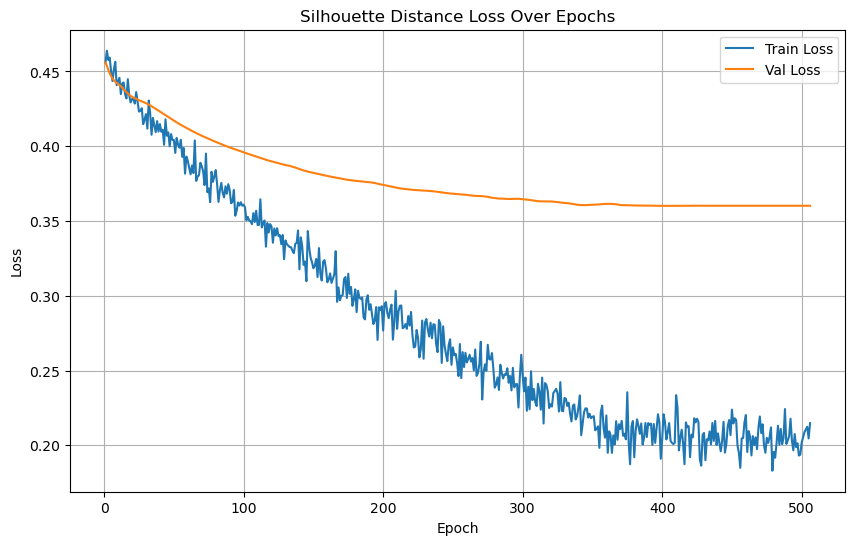

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.2563
Test Batch [20/667], Loss: 0.2323


Test Batch [30/667], Loss: 0.2822
Test Batch [40/667], Loss: 0.4110


Test Batch [50/667], Loss: 0.3796
Test Batch [60/667], Loss: 0.3479


Test Batch [70/667], Loss: 0.2061
Test Batch [80/667], Loss: 0.2344


Test Batch [90/667], Loss: 0.2649
Test Batch [100/667], Loss: 0.2146


Test Batch [110/667], Loss: 0.2118
Test Batch [120/667], Loss: 0.1680
Test Batch [130/667], Loss: 0.2728


Test Batch [140/667], Loss: 0.2246


Test Batch [150/667], Loss: 0.2515
Test Batch [160/667], Loss: 0.2789
Test Batch [170/667], Loss: 0.2345
Test Batch [180/667], Loss: 0.5000
Test Batch [190/667], Loss: 0.2570


Test Batch [200/667], Loss: 0.5000
Test Batch [210/667], Loss: 0.5000


Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.1751
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.2489


Test Batch [320/667], Loss: 0.2445


Test Batch [330/667], Loss: 0.2865
Test Batch [340/667], Loss: 0.2105


Test Batch [350/667], Loss: 0.2184


Test Batch [360/667], Loss: 0.2441
Test Batch [370/667], Loss: 0.2001


Test Batch [380/667], Loss: 0.3166


Test Batch [390/667], Loss: 0.2000
Test Batch [400/667], Loss: 0.1265


Test Batch [410/667], Loss: 0.2369


Test Batch [420/667], Loss: 0.2796
Test Batch [430/667], Loss: 0.2691


Test Batch [440/667], Loss: 0.3179


Test Batch [450/667], Loss: 0.2468
Test Batch [460/667], Loss: 0.4064
Test Batch [470/667], Loss: 0.4351


Test Batch [480/667], Loss: 0.4209
Test Batch [490/667], Loss: 0.3872
Test Batch [500/667], Loss: 0.2245


Test Batch [510/667], Loss: 0.2780
Test Batch [520/667], Loss: 0.2898
Test Batch [530/667], Loss: 0.5000
Test Batch [540/667], Loss: 0.2747


Test Batch [550/667], Loss: 0.5000
Test Batch [560/667], Loss: 0.3169
Test Batch [570/667], Loss: 0.3259
Test Batch [580/667], Loss: 0.1989


Test Batch [590/667], Loss: 0.3456
Test Batch [600/667], Loss: 0.4610
Test Batch [610/667], Loss: 0.3515
Test Batch [620/667], Loss: 0.3250


Test Batch [630/667], Loss: 0.4186
Test Batch [640/667], Loss: 0.2596
Test Batch [650/667], Loss: 0.4116


Test Batch [660/667], Loss: 0.4032

Test Loss: 0.3169


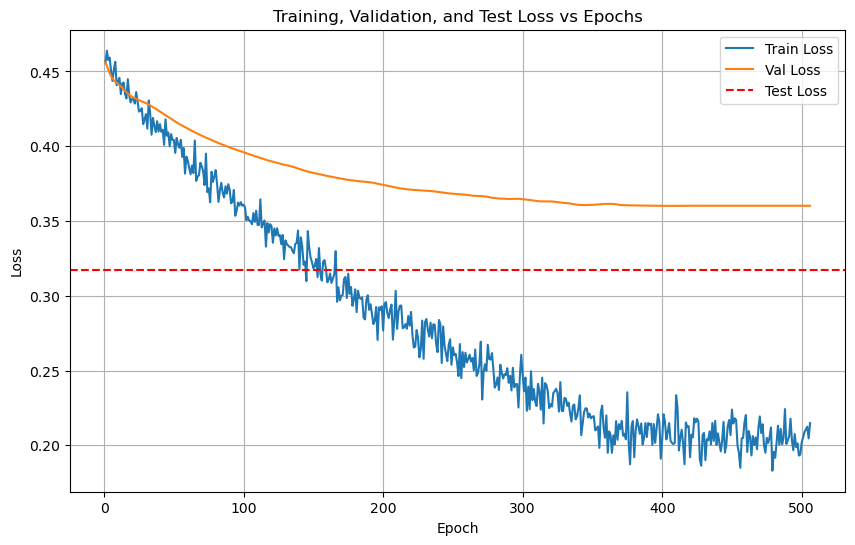

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/667 for test dataset.


  Processed batch 20/667 for test dataset.
  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.


  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.


  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.


  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.
  Processed batch 140/667 for test dataset.


  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.
  Processed batch 180/667 for test dataset.


  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.


  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.


  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.


  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.


  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.


  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.
  Processed batch 370/667 for test dataset.


  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.
  Processed batch 410/667 for test dataset.


  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.
  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.


  Processed batch 460/667 for test dataset.
  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.


  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.
  Processed batch 520/667 for test dataset.


  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.


  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.


  Processed batch 590/667 for test dataset.
  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.


  Processed batch 620/667 for test dataset.
  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.


  Processed batch 650/667 for test dataset.
  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.57      0.80      0.67         5
           2       0.67      0.40      0.50         5
           3       1.00      0.60      0.75         5
           4       1.00      1.00      1.00         5
           5       0.60      0.60      0.60         5
           6       0.67      0.80      0.73         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5

    accuracy                           0.73        45
   macro avg       0.76      0.73      0.73        45
weighted avg       0.76      0.73      0.73        45


LOG: Evaluating on the test set...
Test Accuracy: 64.11%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3038  |  Val Loss: 2.2933
Validation loss improved from inf to 2.2933.
[Epoch 2/1000] Train Loss: 2.2888  |  Val Loss: 2.2814
Validation loss improved from 2.2933 to 2.2814.
[Epoch 3/1000] Train Loss: 2.2739  |  Val Loss: 2.2699
Validation loss improved from 2.2814 to 2.2699.
[Epoch 4/1000] Train Loss: 2.2592  |  Val Loss: 2.2587
Validation loss improved from 2.2699 to 2.2587.
[Epoch 5/1000] Train Loss: 2.2446  |  Val Loss: 2.2476
Validation loss improved from 2.2587 to 2.2476.
[Epoch 6/1000] Train Loss: 2.2300  |  Val Loss: 2.2366
Validation loss improved from 2.2476 to 2.2366.
[Epoch 7/1000] Train Loss: 2.2156  |  Val Loss: 2.2257
Validation loss improved from 2.2366 to 2.2257.
[Epoch 8/1000] Train Loss: 2.2014  |  Val Loss: 2.2148
Validation loss improved from 2.2257 to 2.2148.
[Epoch 9/1000] Train Loss: 2.1873  |  Val Loss: 2.2038
Validation loss improved from 2.2148 to 2.2038.
[Epoch 10/1000] Train Loss: 2.1734  |  Val Loss: 2.1931
Validation loss impr

[Epoch 57/1000] Train Loss: 1.7186  |  Val Loss: 1.8500
Validation loss improved from 1.8554 to 1.8500.
[Epoch 58/1000] Train Loss: 1.7111  |  Val Loss: 1.8447
Validation loss improved from 1.8500 to 1.8447.
[Epoch 59/1000] Train Loss: 1.7038  |  Val Loss: 1.8393
Validation loss improved from 1.8447 to 1.8393.
[Epoch 60/1000] Train Loss: 1.6964  |  Val Loss: 1.8339
Validation loss improved from 1.8393 to 1.8339.
[Epoch 61/1000] Train Loss: 1.6891  |  Val Loss: 1.8285
Validation loss improved from 1.8339 to 1.8285.
[Epoch 62/1000] Train Loss: 1.6817  |  Val Loss: 1.8229
Validation loss improved from 1.8285 to 1.8229.
[Epoch 63/1000] Train Loss: 1.6742  |  Val Loss: 1.8175
Validation loss improved from 1.8229 to 1.8175.
[Epoch 64/1000] Train Loss: 1.6666  |  Val Loss: 1.8118
Validation loss improved from 1.8175 to 1.8118.
[Epoch 65/1000] Train Loss: 1.6588  |  Val Loss: 1.8062
Validation loss improved from 1.8118 to 1.8062.
[Epoch 66/1000] Train Loss: 1.6510  |  Val Loss: 1.8005
Validati

[Epoch 70/1000] Train Loss: 1.6199  |  Val Loss: 1.7780
Validation loss improved from 1.7836 to 1.7780.
[Epoch 71/1000] Train Loss: 1.6122  |  Val Loss: 1.7724
Validation loss improved from 1.7780 to 1.7724.
[Epoch 72/1000] Train Loss: 1.6044  |  Val Loss: 1.7669
Validation loss improved from 1.7724 to 1.7669.
[Epoch 73/1000] Train Loss: 1.5967  |  Val Loss: 1.7614
Validation loss improved from 1.7669 to 1.7614.
[Epoch 74/1000] Train Loss: 1.5890  |  Val Loss: 1.7560
Validation loss improved from 1.7614 to 1.7560.
[Epoch 75/1000] Train Loss: 1.5814  |  Val Loss: 1.7506
Validation loss improved from 1.7560 to 1.7506.
[Epoch 76/1000] Train Loss: 1.5739  |  Val Loss: 1.7452
Validation loss improved from 1.7506 to 1.7452.
[Epoch 77/1000] Train Loss: 1.5664  |  Val Loss: 1.7398
Validation loss improved from 1.7452 to 1.7398.
[Epoch 78/1000] Train Loss: 1.5589  |  Val Loss: 1.7344
Validation loss improved from 1.7398 to 1.7344.
[Epoch 79/1000] Train Loss: 1.5515  |  Val Loss: 1.7291
Validati

[Epoch 137/1000] Train Loss: 1.1543  |  Val Loss: 1.4630
Validation loss improved from 1.4670 to 1.4630.
[Epoch 138/1000] Train Loss: 1.1479  |  Val Loss: 1.4589
Validation loss improved from 1.4630 to 1.4589.
[Epoch 139/1000] Train Loss: 1.1415  |  Val Loss: 1.4549
Validation loss improved from 1.4589 to 1.4549.
[Epoch 140/1000] Train Loss: 1.1351  |  Val Loss: 1.4509
Validation loss improved from 1.4549 to 1.4509.
[Epoch 141/1000] Train Loss: 1.1288  |  Val Loss: 1.4469
Validation loss improved from 1.4509 to 1.4469.
[Epoch 142/1000] Train Loss: 1.1225  |  Val Loss: 1.4429
Validation loss improved from 1.4469 to 1.4429.
[Epoch 143/1000] Train Loss: 1.1161  |  Val Loss: 1.4389
Validation loss improved from 1.4429 to 1.4389.
[Epoch 144/1000] Train Loss: 1.1099  |  Val Loss: 1.4349
Validation loss improved from 1.4389 to 1.4349.
[Epoch 145/1000] Train Loss: 1.1036  |  Val Loss: 1.4309
Validation loss improved from 1.4349 to 1.4309.
[Epoch 146/1000] Train Loss: 1.0973  |  Val Loss: 1.426

[Epoch 210/1000] Train Loss: 0.7305  |  Val Loss: 1.1893
Validation loss improved from 1.1927 to 1.1893.
[Epoch 211/1000] Train Loss: 0.7254  |  Val Loss: 1.1860
Validation loss improved from 1.1893 to 1.1860.
[Epoch 212/1000] Train Loss: 0.7202  |  Val Loss: 1.1827
Validation loss improved from 1.1860 to 1.1827.
[Epoch 213/1000] Train Loss: 0.7151  |  Val Loss: 1.1794
Validation loss improved from 1.1827 to 1.1794.
[Epoch 214/1000] Train Loss: 0.7101  |  Val Loss: 1.1761
Validation loss improved from 1.1794 to 1.1761.
[Epoch 215/1000] Train Loss: 0.7050  |  Val Loss: 1.1728
Validation loss improved from 1.1761 to 1.1728.
[Epoch 216/1000] Train Loss: 0.7000  |  Val Loss: 1.1696
Validation loss improved from 1.1728 to 1.1696.
[Epoch 217/1000] Train Loss: 0.6950  |  Val Loss: 1.1663
Validation loss improved from 1.1696 to 1.1663.
[Epoch 218/1000] Train Loss: 0.6901  |  Val Loss: 1.1631
Validation loss improved from 1.1663 to 1.1631.
[Epoch 219/1000] Train Loss: 0.6851  |  Val Loss: 1.160

[Epoch 287/1000] Train Loss: 0.3987  |  Val Loss: 0.9883
Validation loss improved from 0.9900 to 0.9883.
[Epoch 288/1000] Train Loss: 0.3953  |  Val Loss: 0.9865
Validation loss improved from 0.9883 to 0.9865.
[Epoch 289/1000] Train Loss: 0.3919  |  Val Loss: 0.9848
Validation loss improved from 0.9865 to 0.9848.
[Epoch 290/1000] Train Loss: 0.3885  |  Val Loss: 0.9831
Validation loss improved from 0.9848 to 0.9831.
[Epoch 291/1000] Train Loss: 0.3852  |  Val Loss: 0.9815
Validation loss improved from 0.9831 to 0.9815.
[Epoch 292/1000] Train Loss: 0.3819  |  Val Loss: 0.9799
Validation loss improved from 0.9815 to 0.9799.
[Epoch 293/1000] Train Loss: 0.3786  |  Val Loss: 0.9783
Validation loss improved from 0.9799 to 0.9783.
[Epoch 294/1000] Train Loss: 0.3753  |  Val Loss: 0.9767
Validation loss improved from 0.9783 to 0.9767.
[Epoch 295/1000] Train Loss: 0.3721  |  Val Loss: 0.9752
Validation loss improved from 0.9767 to 0.9752.
[Epoch 296/1000] Train Loss: 0.3689  |  Val Loss: 0.973

[Epoch 361/1000] Train Loss: 0.2050  |  Val Loss: 0.9214
Validation loss improved from 0.9217 to 0.9214.
[Epoch 362/1000] Train Loss: 0.2031  |  Val Loss: 0.9212
Validation loss improved from 0.9214 to 0.9212.
[Epoch 363/1000] Train Loss: 0.2013  |  Val Loss: 0.9210
Validation loss improved from 0.9212 to 0.9210.
[Epoch 364/1000] Train Loss: 0.1994  |  Val Loss: 0.9208
Validation loss improved from 0.9210 to 0.9208.
[Epoch 365/1000] Train Loss: 0.1976  |  Val Loss: 0.9206
Validation loss improved from 0.9208 to 0.9206.
[Epoch 366/1000] Train Loss: 0.1958  |  Val Loss: 0.9204
Validation loss improved from 0.9206 to 0.9204.
[Epoch 367/1000] Train Loss: 0.1940  |  Val Loss: 0.9202
Validation loss improved from 0.9204 to 0.9202.
[Epoch 368/1000] Train Loss: 0.1922  |  Val Loss: 0.9200
Validation loss improved from 0.9202 to 0.9200.
[Epoch 369/1000] Train Loss: 0.1904  |  Val Loss: 0.9199
Validation loss improved from 0.9200 to 0.9199.
[Epoch 370/1000] Train Loss: 0.1887  |  Val Loss: 0.919

[Epoch 441/1000] Train Loss: 0.1008  |  Val Loss: 0.9341
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 442/1000] Train Loss: 0.1000  |  Val Loss: 0.9346
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 443/1000] Train Loss: 0.0992  |  Val Loss: 0.9351
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 444/1000] Train Loss: 0.0984  |  Val Loss: 0.9355
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 445/1000] Train Loss: 0.0976  |  Val Loss: 0.9360
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 446/1000] Train Loss: 0.0968  |  Val Loss: 0.9365
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 447/1000] Train Loss: 0.0960  |  Val Loss: 0.9370
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 448/1000] Train Loss: 0.0952  |  Val Loss: 0.9375
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 449/1000] Train Loss: 0.0945  |  Val Loss: 0.9380
!! Validation loss did NOT improve !! Patience:

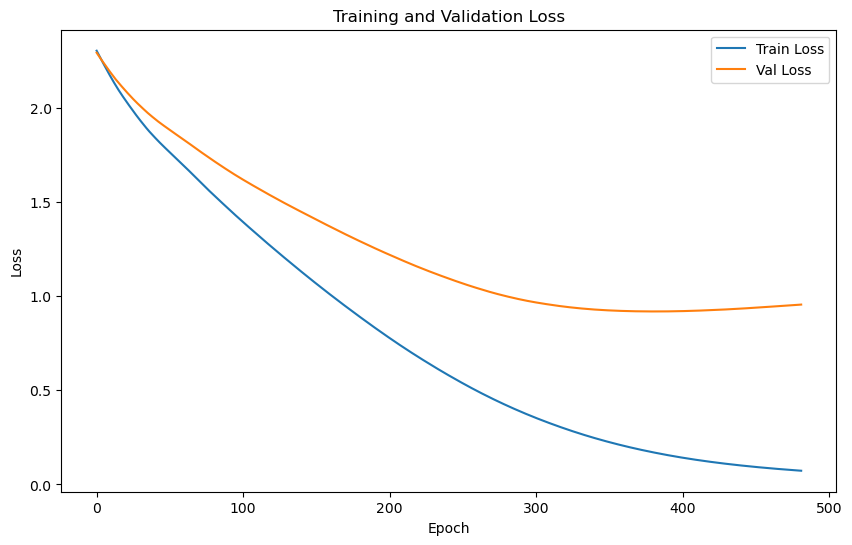

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.5651 | Test Accuracy: 64.68%


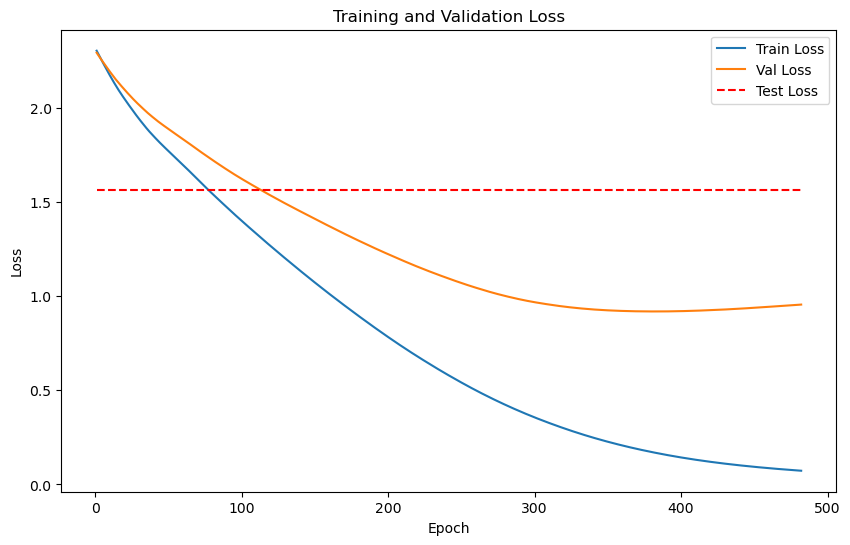

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


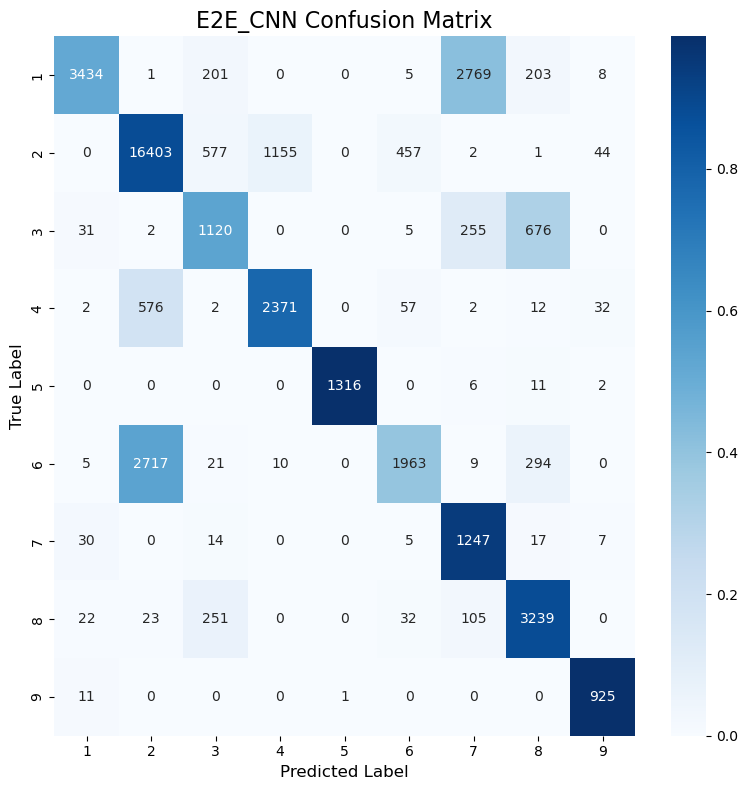

Classification Accuracy: 75.01%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


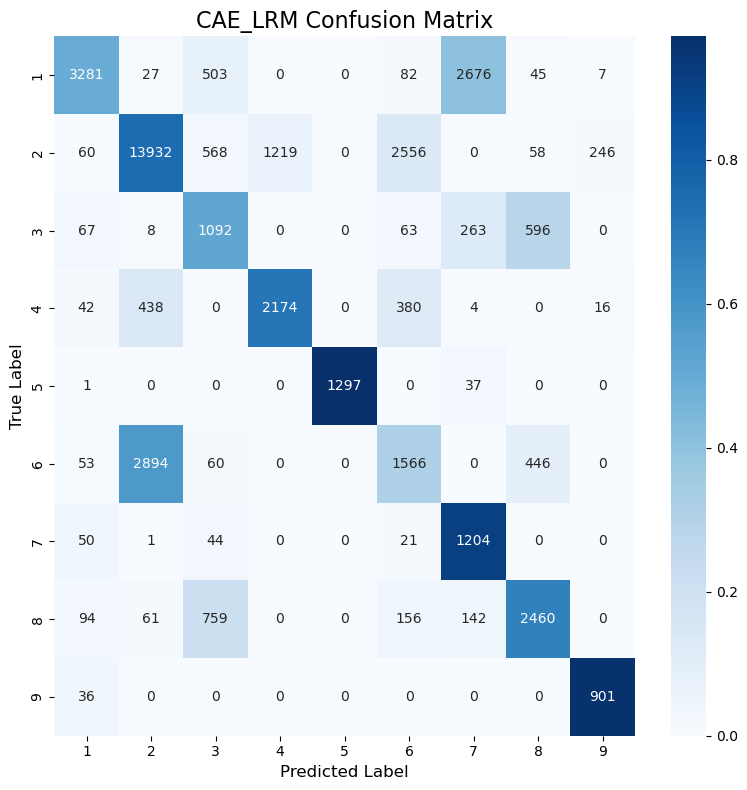

Classification Accuracy: 65.38%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


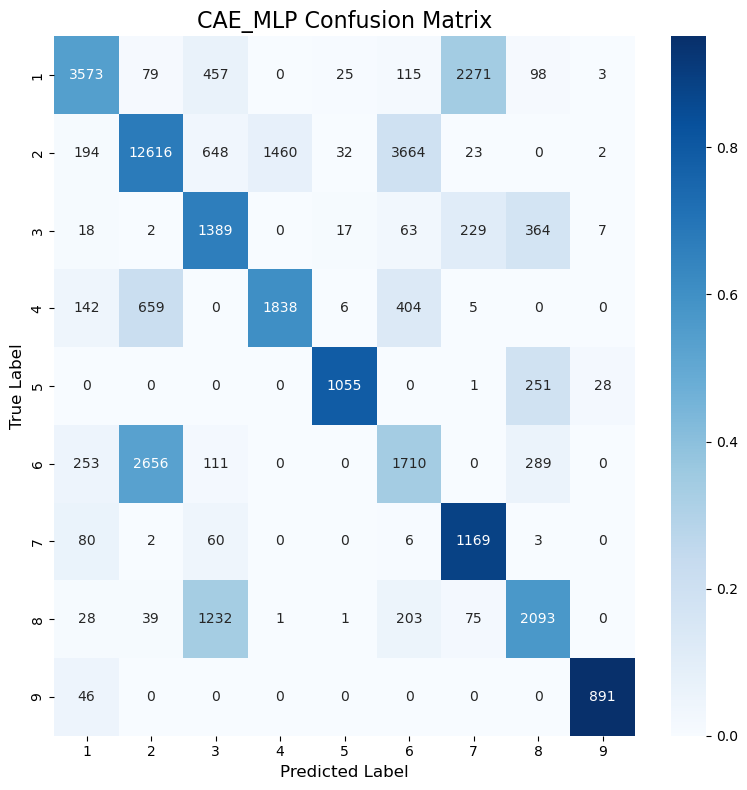

Classification Accuracy: 61.69%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


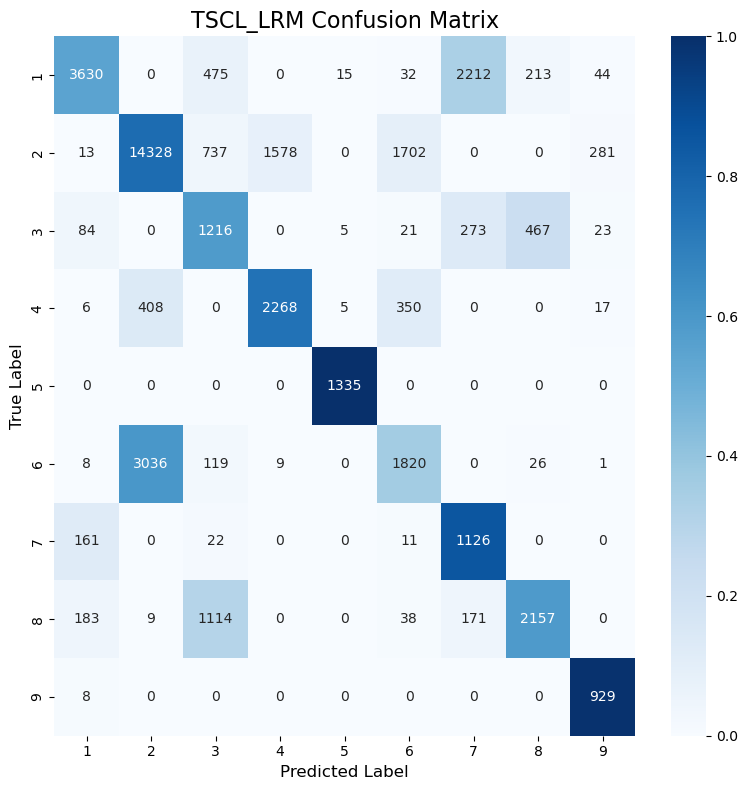

Classification Accuracy: 67.49%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


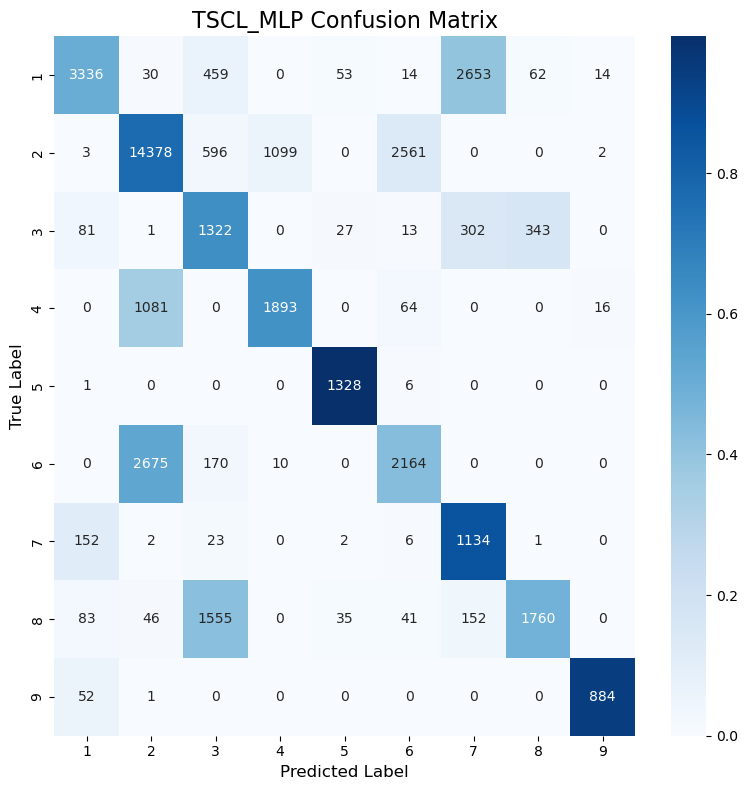

Classification Accuracy: 66.06%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


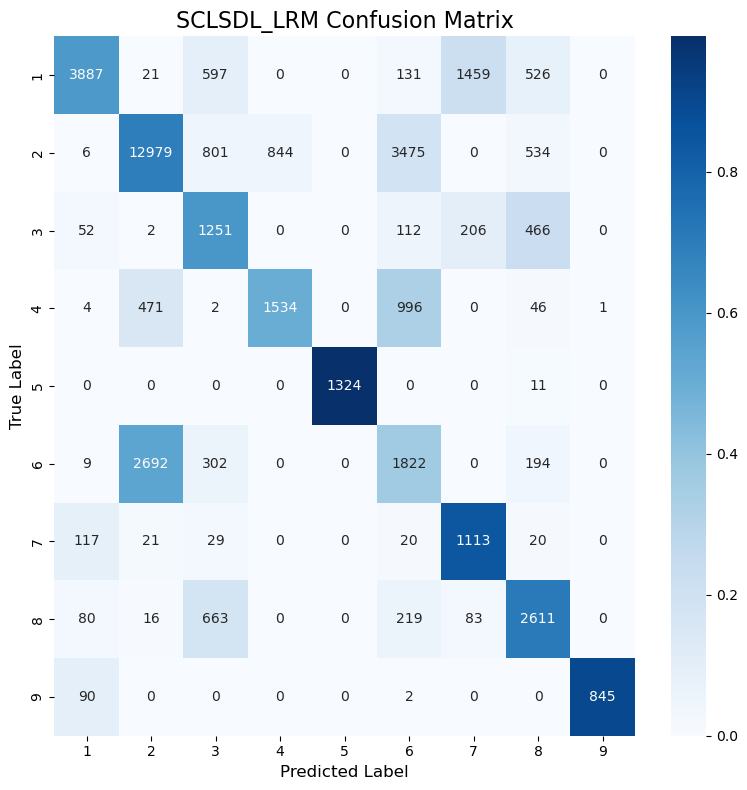

Classification Accuracy: 64.11%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


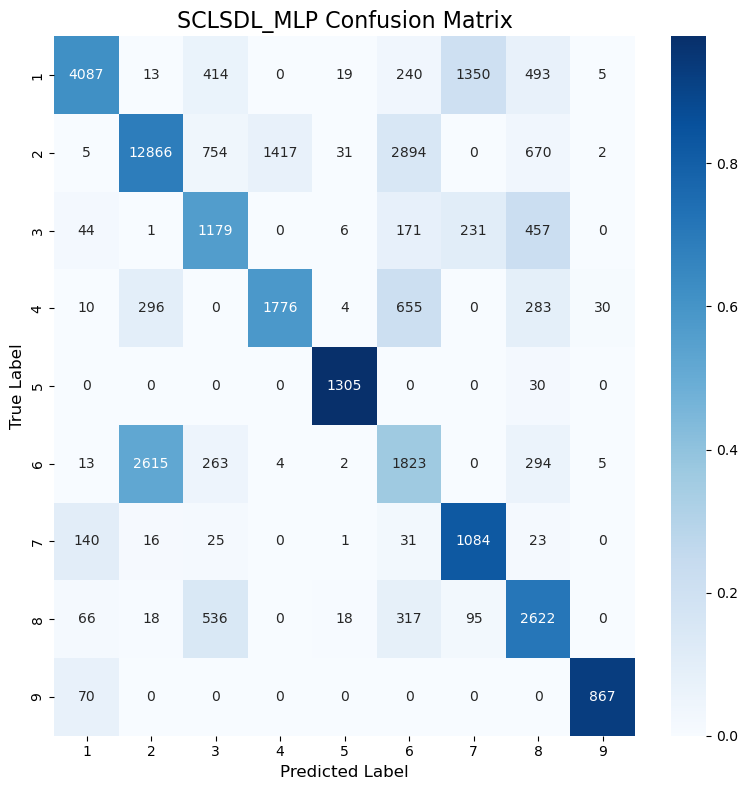

Classification Accuracy: 64.68%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          75.01
1    LRM (CAE)          65.38
2    MLP (CAE)          61.69
3     TSCL LRM          67.49
4     TSCL MLP          66.06
5  SCL_SDL LRM          64.11
6  SCL_SDL MLP          64.68

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          75.01
3     TSCL LRM          67.49
4     TSCL MLP          66.06
1    LRM (CAE)          65.38
6  SCL_SDL MLP          64.68
5  SCL_SDL LRM          64.11
2    MLP (CAE)          61.69
